In [1]:
import pathlib
import pickle


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 500)

In [2]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)

/home/fernando/6/machinelearning/machine_learning/CSRoundPrediction/data


In [3]:
processed_file_path = DATA_DIR / 'processed' / 'csgo.pkl'

with open(processed_file_path, 'rb') as file:
    (
        data,
        continuous_variables,
        discrete_variables,
        categorical_variables,
    ) = pickle.load(file)

# Analyzing features individually

First it is fair to explain a little what we are analysing here. Counter-Strike is a computer game where two teams face each other, the terrorists (T), and the counter-terrorists (CT). Each of the team has 5 members, each being having 100 armor and being able to buy a variety of weapons, grenades and armor/helmet, by using money they get when the round ends. The rounds last 175 seconds each, and must end with either the Ts winning, by either killing all the CTs before the time ends or by planting a bomb and protecting it for the duration before it blows up. On the other hand, the CTs can win by either killing all the Ts, waiting for the time to run out or defusing the bomb after it is planted. The game ends when one of the teams hit 16, or if the game ties at 15-15, it'll begin a game of whoever wins 4 rounds first, if it ties at 3-3 again the same repeats, indefinetely (yes, it can last a very long time).

## Categorical features


Luckily for us, this dataset only has one categorical feature, the map where the match is being played. However, there is another categorical variable, that is the round winner, being defined as CT or T

In [4]:
def plot_categoricals(data, cols, sorted=True):
    summary = data[cols] \
        .describe() \
        .transpose() \
        .sort_values(by='count')

    print(summary)

    for k, (col, val) in enumerate(summary['count'].items()):
        plt.figure()
        ser = data[col].value_counts()
        if sorted:
            ser = ser.sort_values()
        else:
            ser = ser.sort_index()
        ax = ser.plot.barh()
        for container in ax.containers:
            ax.bar_label(container)
        plt.title(f'{col}, n={int(val)}')
        plt.show()


               count unique         top   freq
map           122410      8  de_inferno  23811
round_winner  122410      2           T  62406


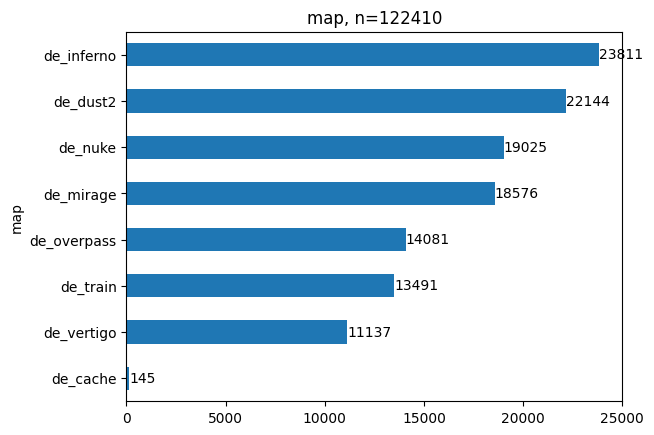

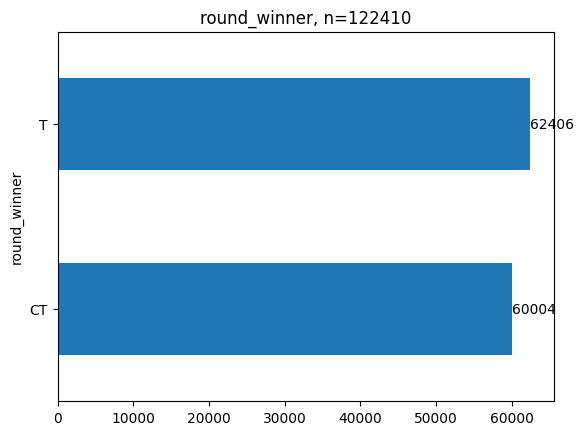

In [5]:
plot_categoricals(data, categorical_variables)

In [6]:
data['map'].value_counts()

map
de_inferno     23811
de_dust2       22144
de_nuke        19025
de_mirage      18576
de_overpass    14081
de_train       13491
de_vertigo     11137
de_cache         145
Name: count, dtype: int64

In [7]:
pd.crosstab(data['map'], data['round_winner'], normalize='index')

round_winner        CT         T
map                             
de_cache      0.710345  0.289655
de_dust2      0.458725  0.541275
de_inferno    0.453992  0.546008
de_mirage     0.492248  0.507752
de_nuke       0.536873  0.463127
de_overpass   0.498970  0.501030
de_train      0.541843  0.458157
de_vertigo    0.470414  0.529586

### Transforming the round winner to a binary 

We can then transform the round winner to a binary value, where it will be 1 if the CTs won or 0 if the Ts won. 

In [8]:
# transformando as variaveis do round_winner em 0 e 1
data['round_winner'] = (data['round_winner'] == 'CT').astype(int)

We'll later on do a one-hot encoding for the map variable to deal with this problem as well

## Looking at numeric values

                                 count          mean           std   min  \
time_left                     122410.0     97.886922     54.465238  0.01   
ct_score                      122410.0      6.709239      4.790362  0.00   
t_score                       122410.0      6.780435      4.823543  0.00   
ct_health                     122410.0    412.106568    132.293290  0.00   
t_health                      122410.0    402.714500    139.919033  0.00   
ct_armor                      122410.0    314.142121    171.029736  0.00   
t_armor                       122410.0    298.444670    174.576545  0.00   
ct_money                      122410.0   9789.023773  11215.042286  0.00   
t_money                       122410.0  11241.036680  12162.806759  0.00   
ct_helmets                    122410.0      2.053901      1.841470  0.00   
t_helmets                     122410.0      2.773638      2.010915  0.00   
ct_defuse_kits                122410.0      1.613724      1.605780  0.00   
ct_players_a

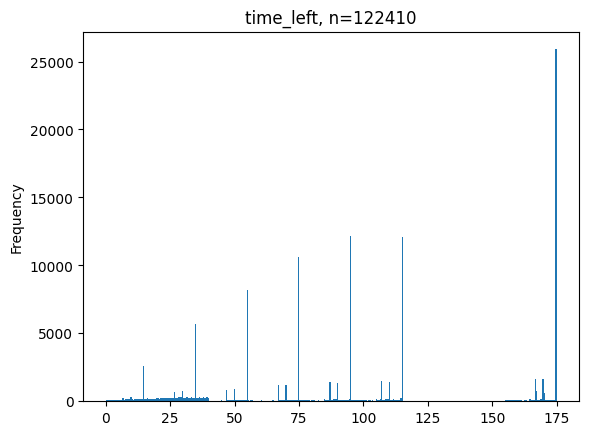

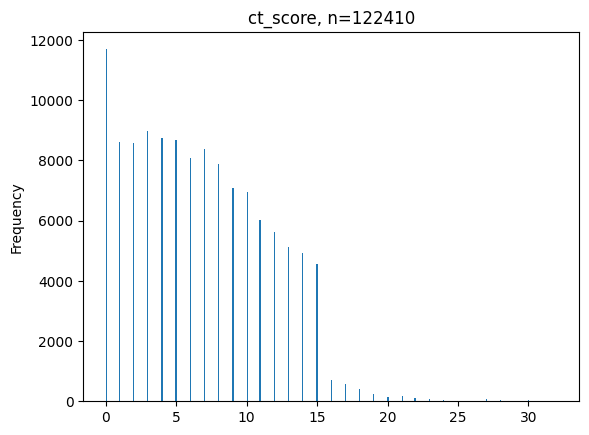

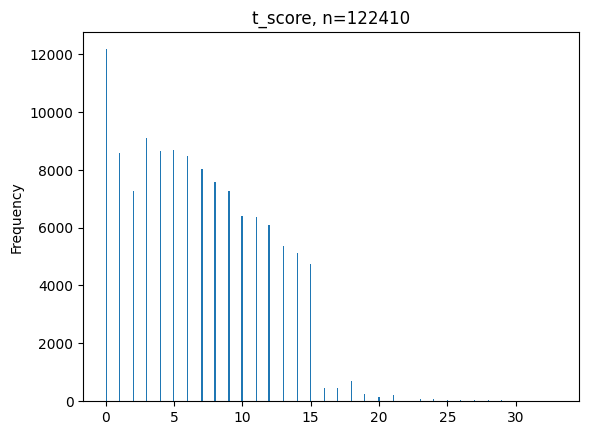

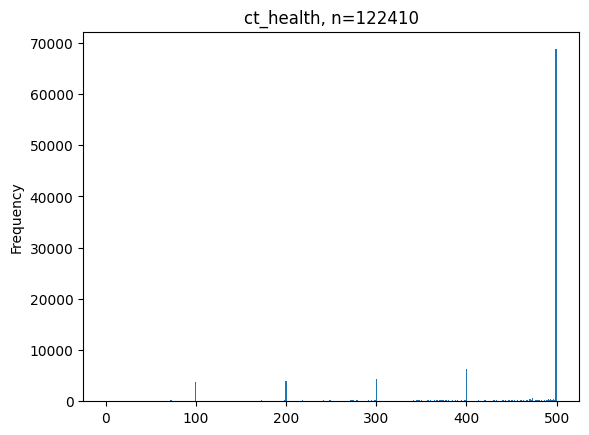

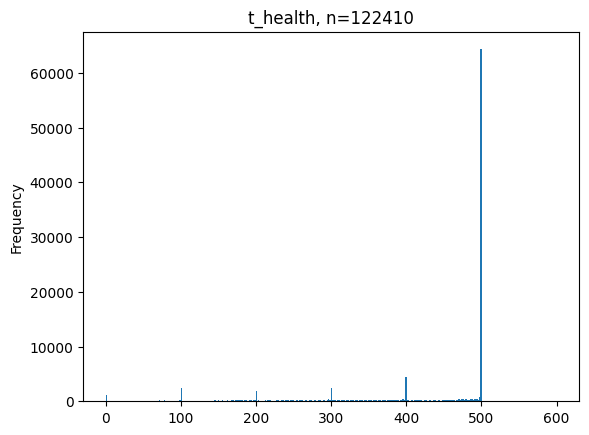

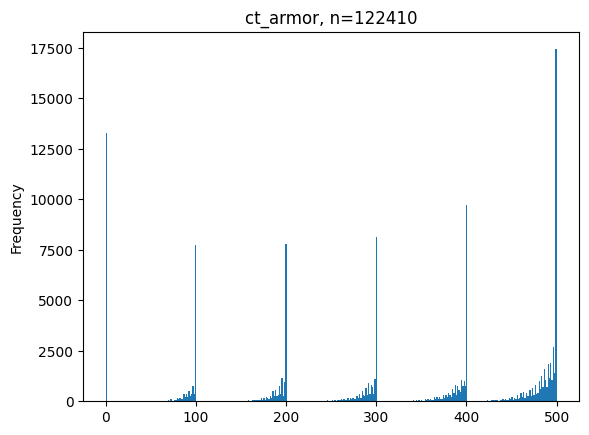

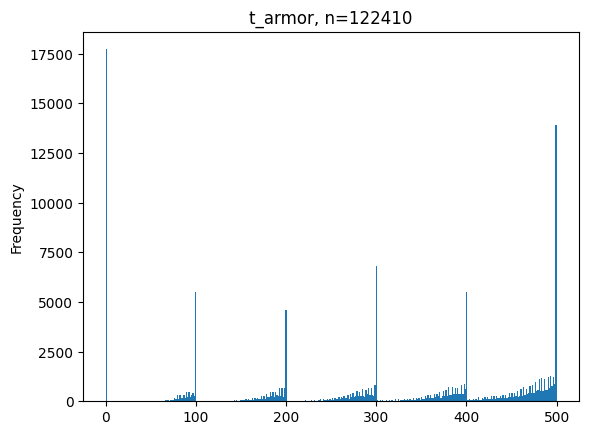

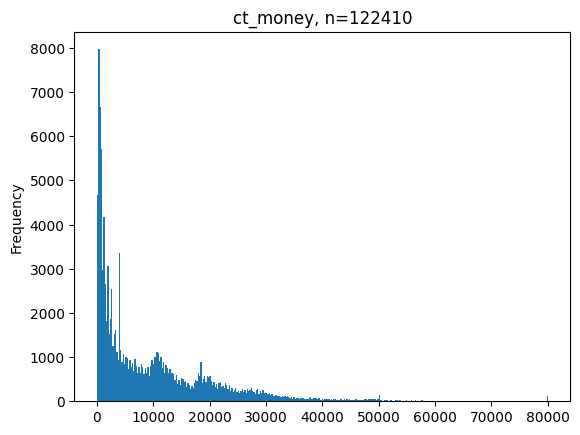

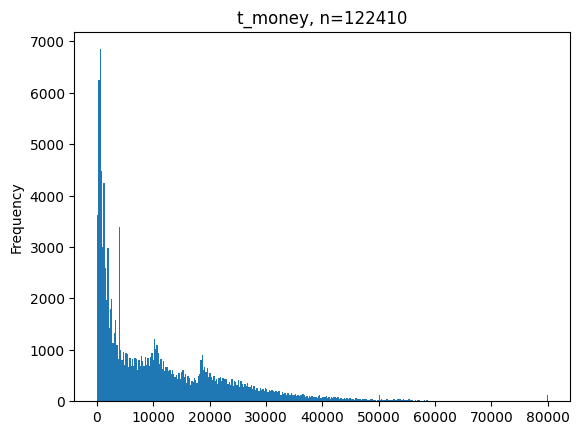

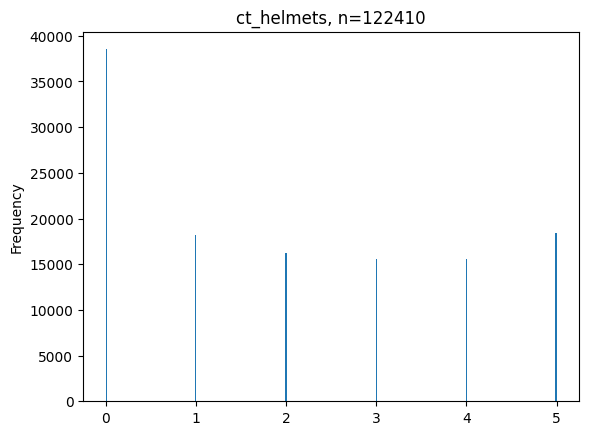

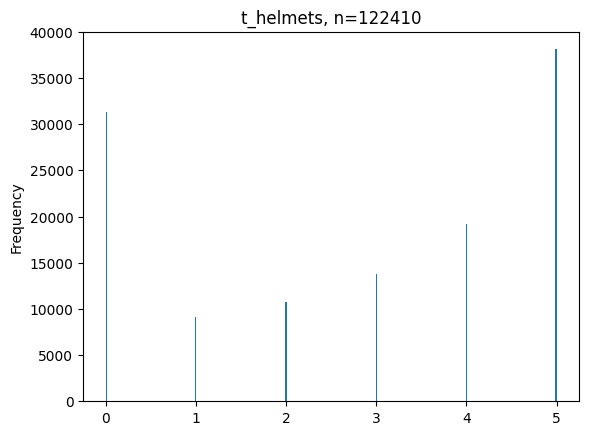

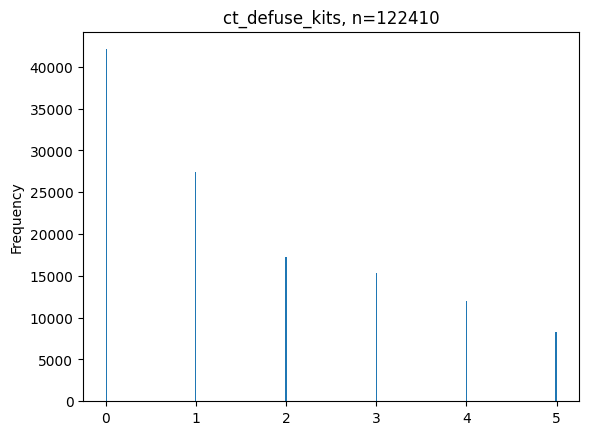

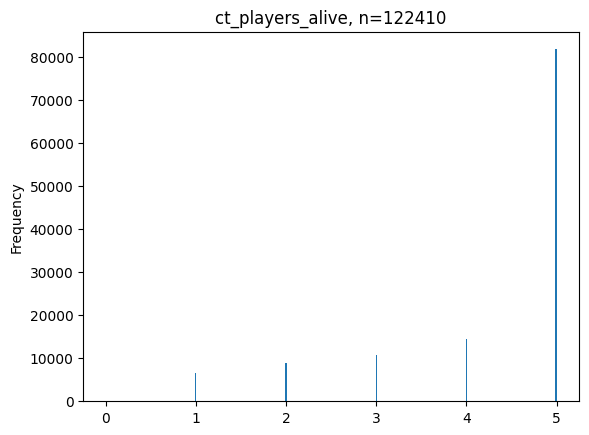

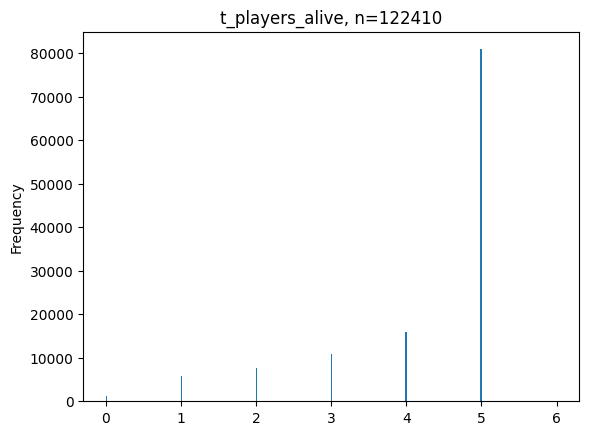

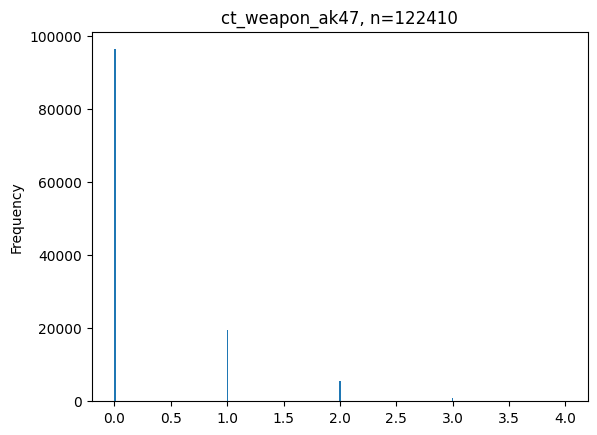

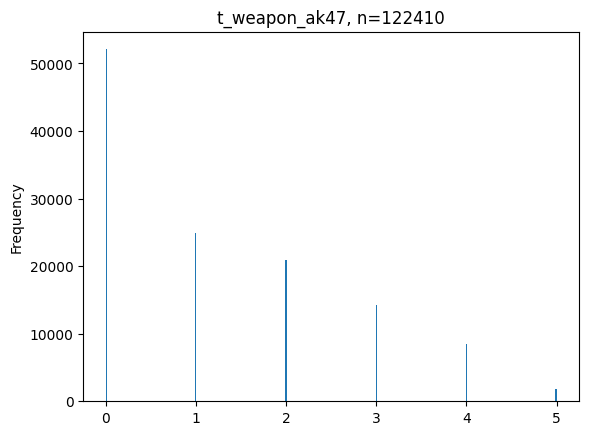

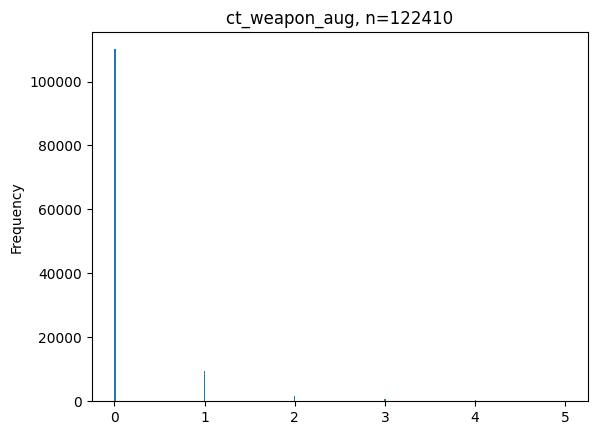

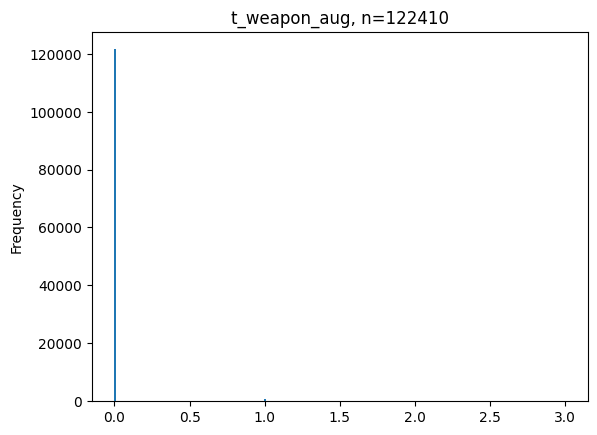

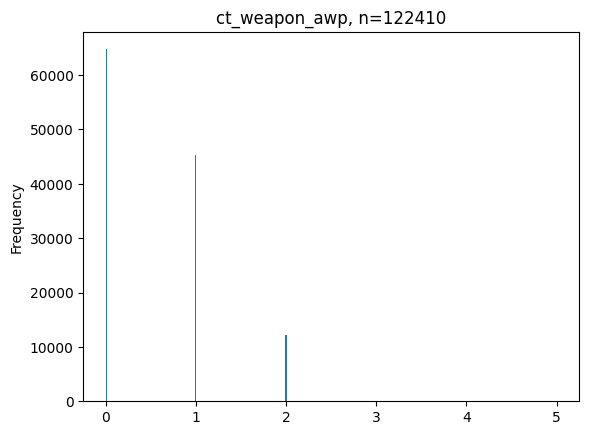

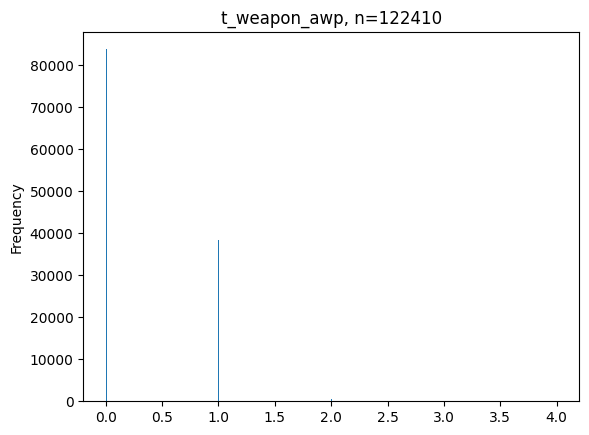

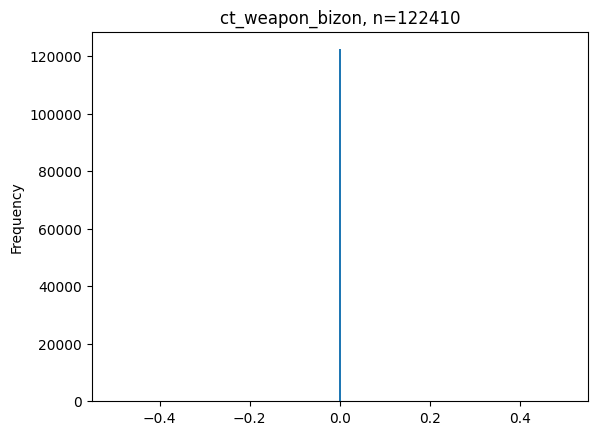

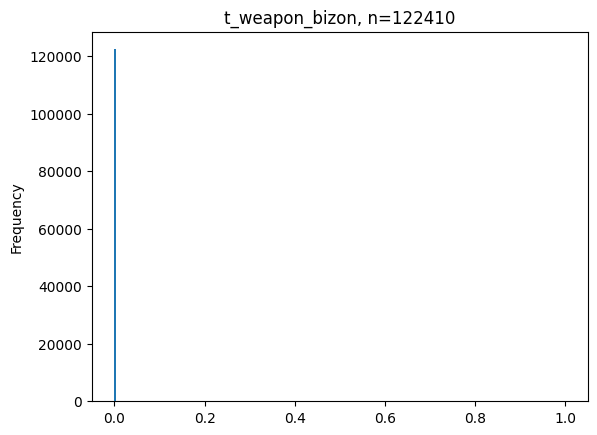

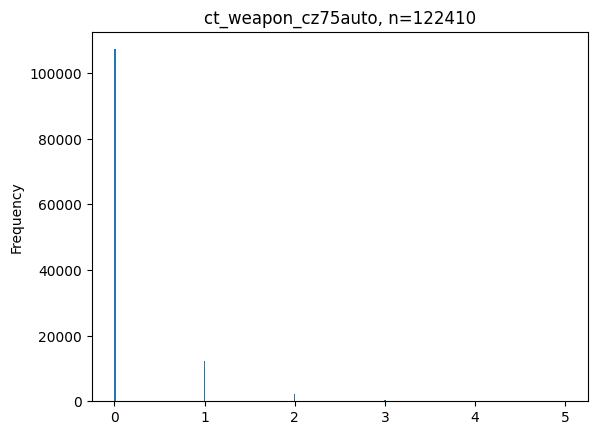

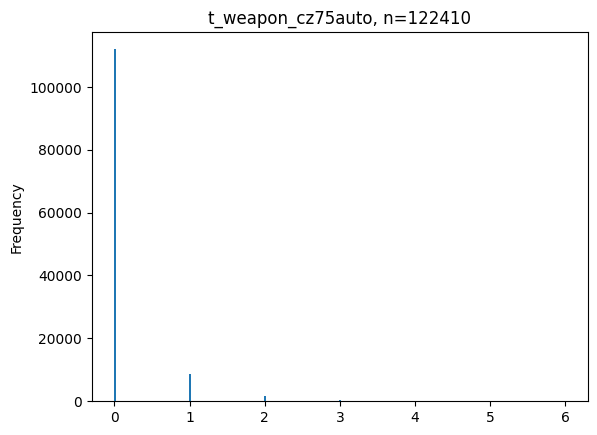

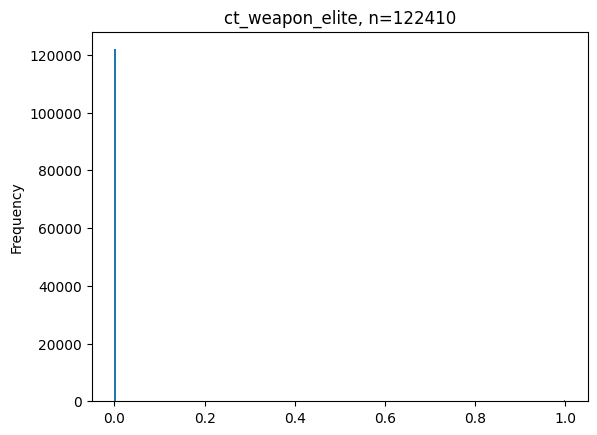

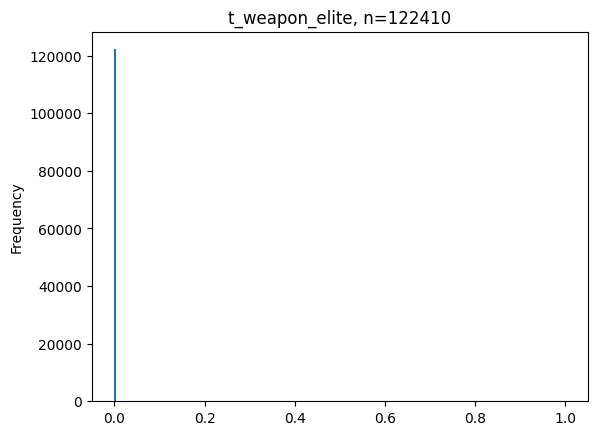

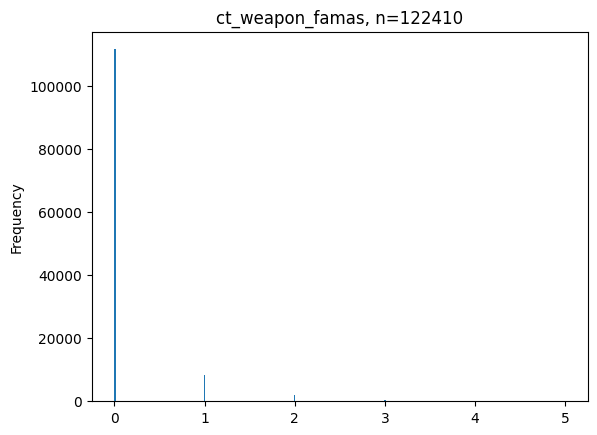

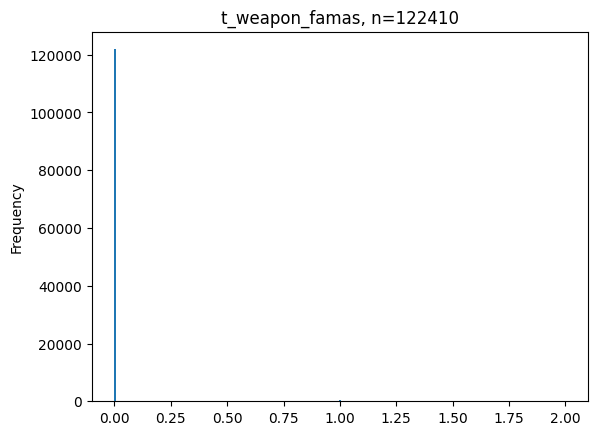

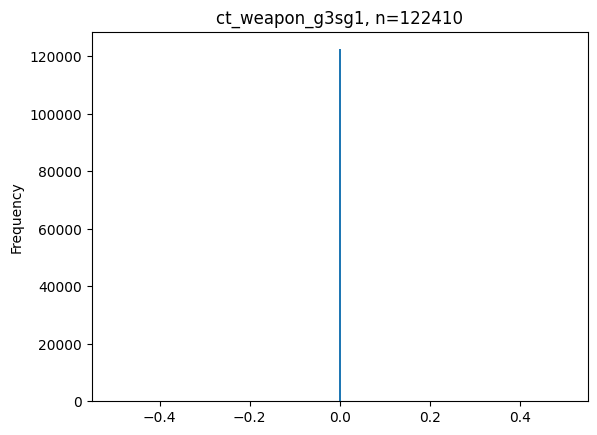

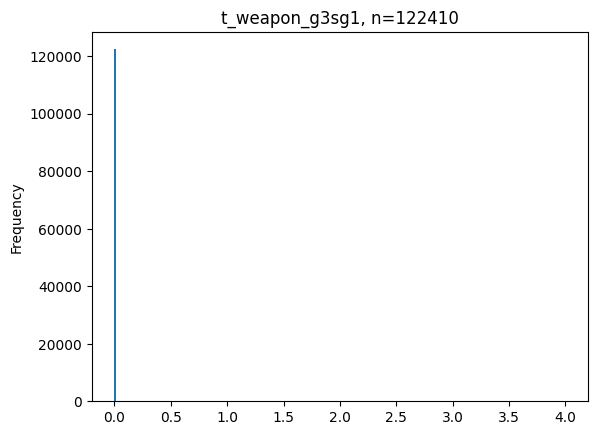

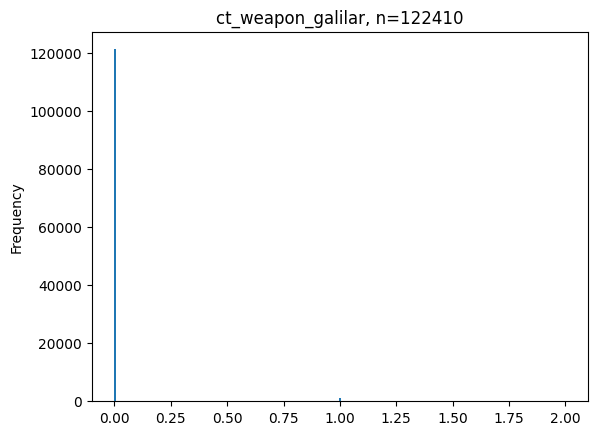

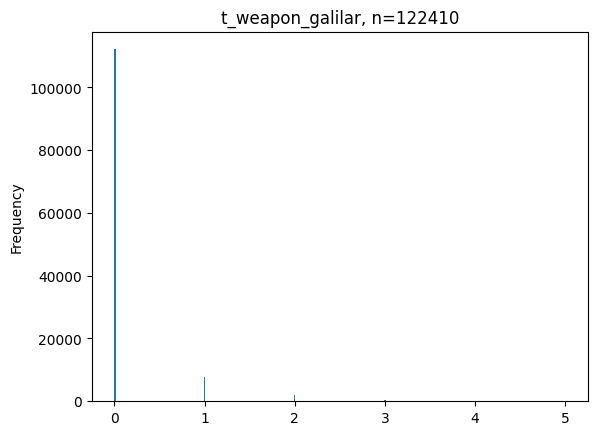

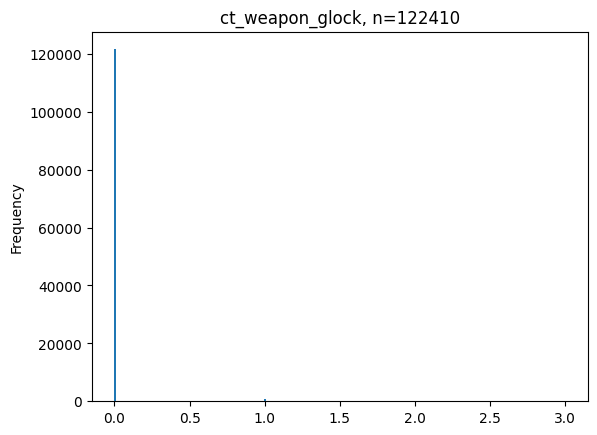

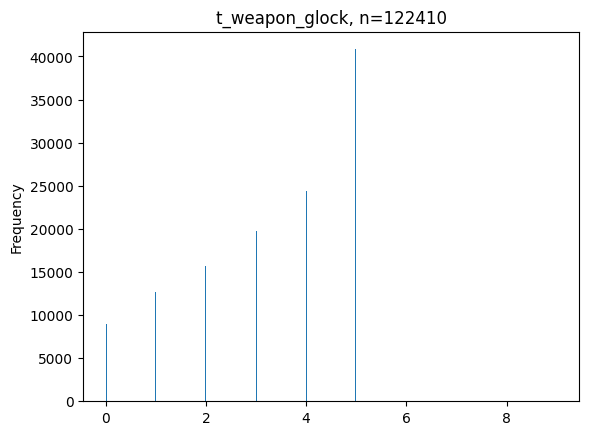

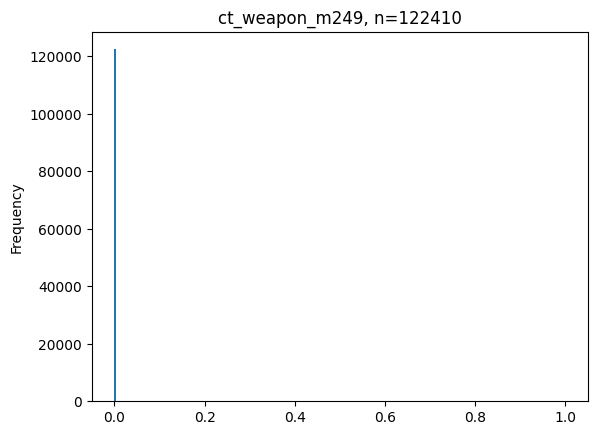

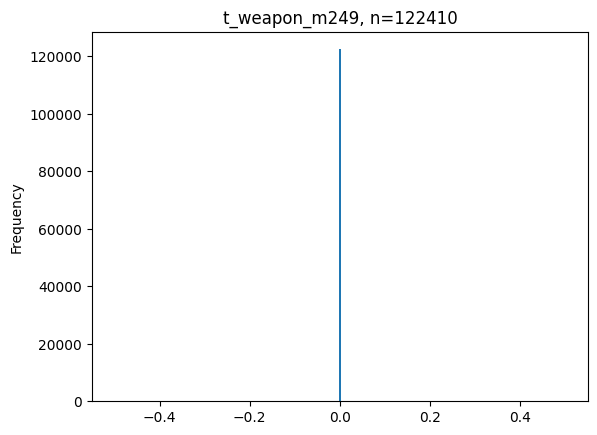

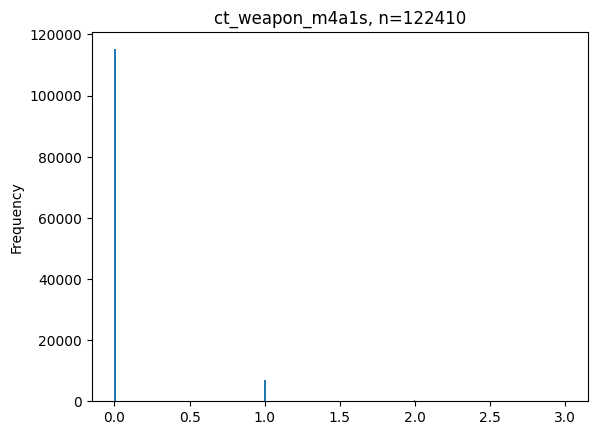

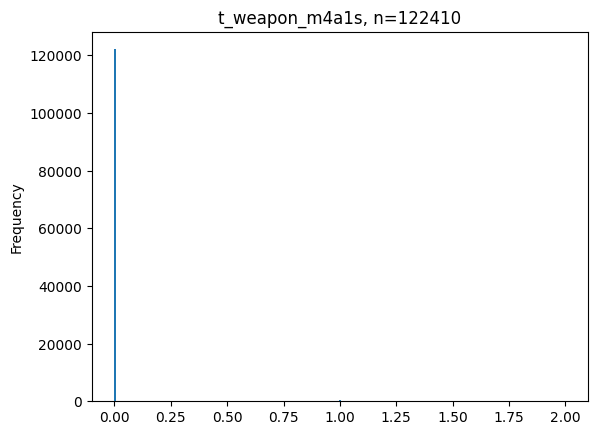

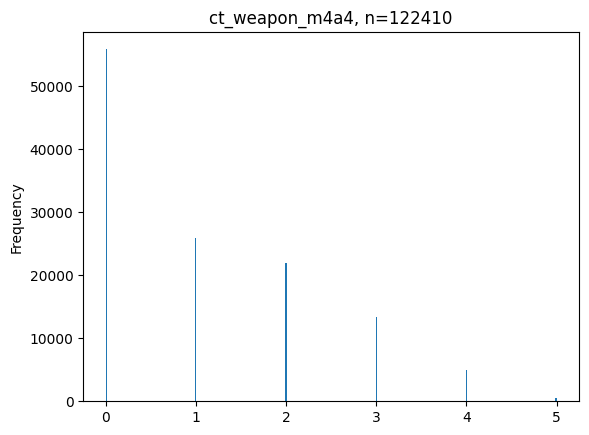

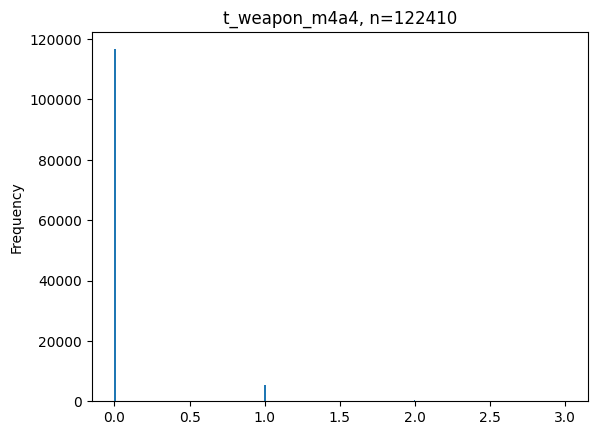

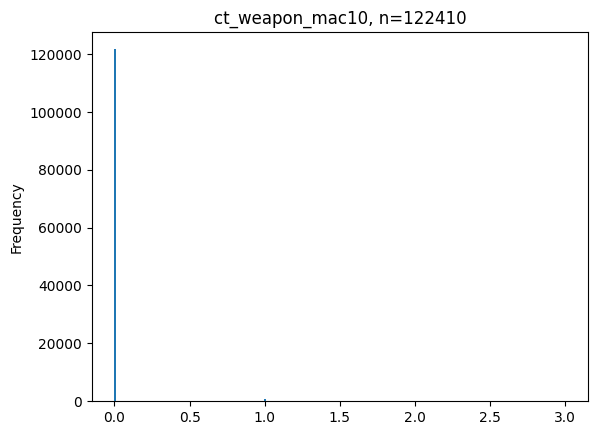

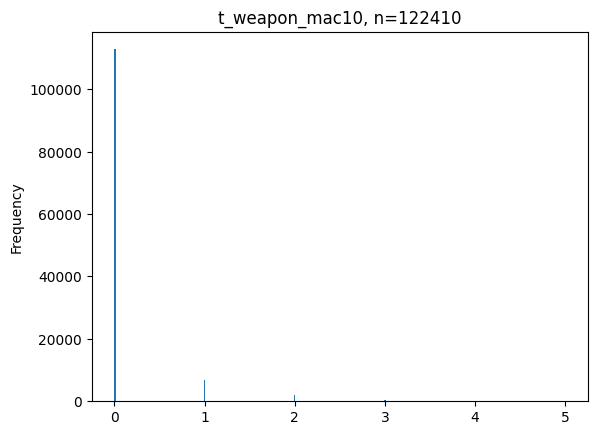

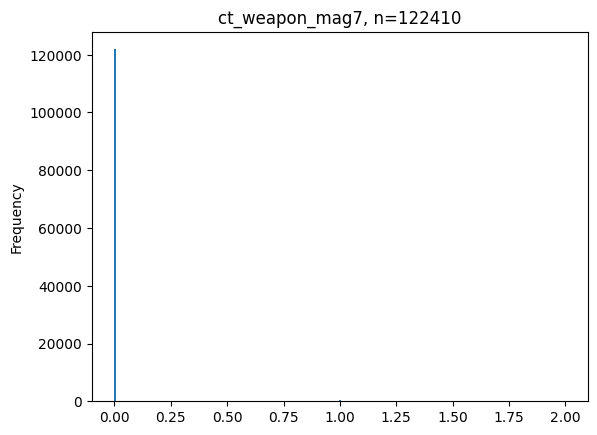

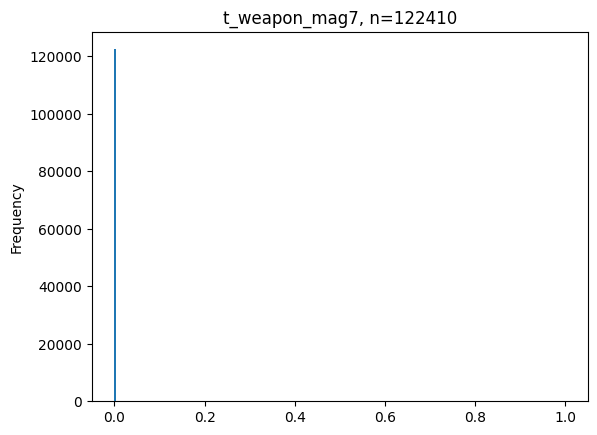

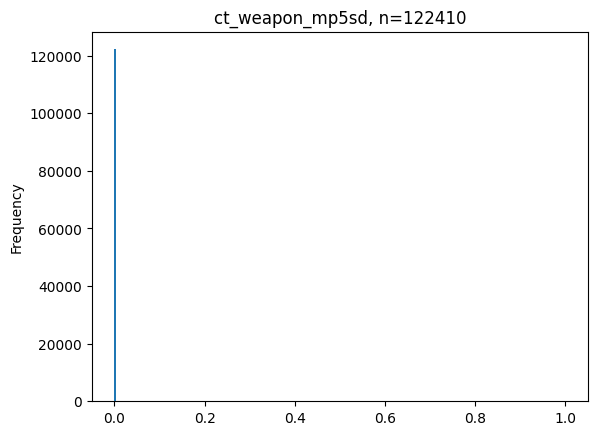

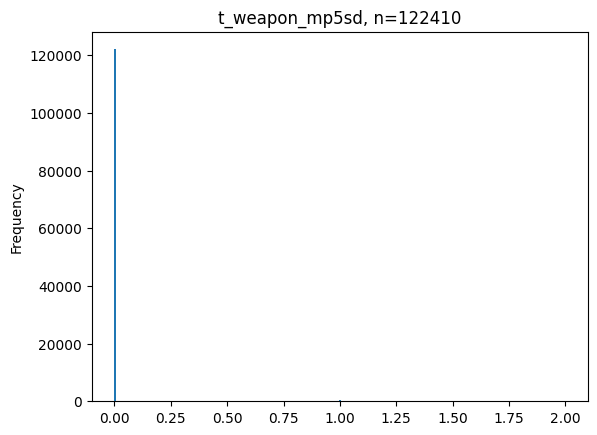

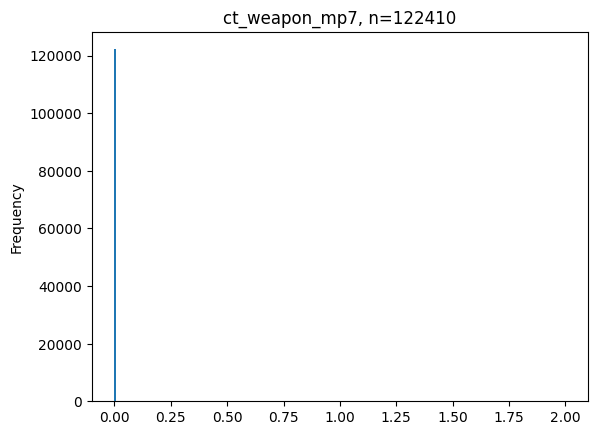

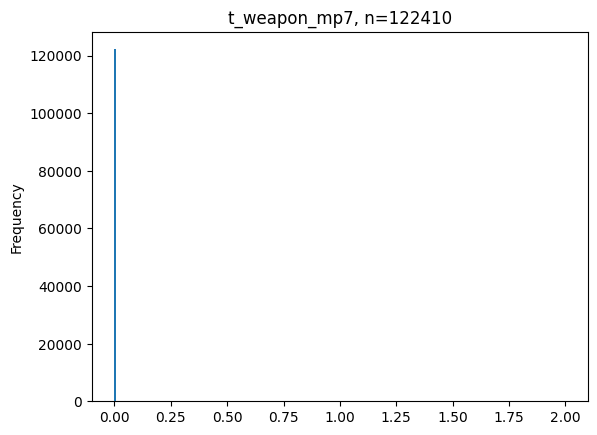

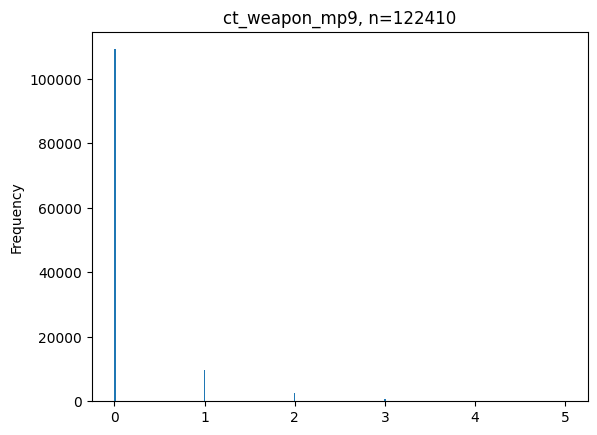

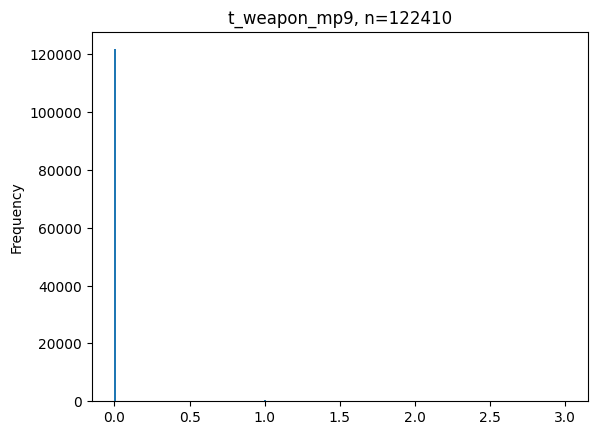

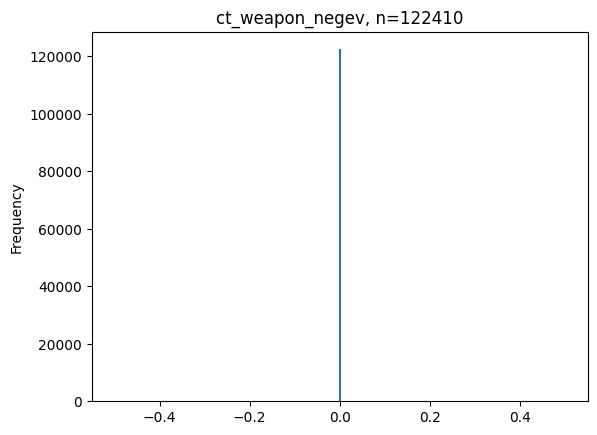

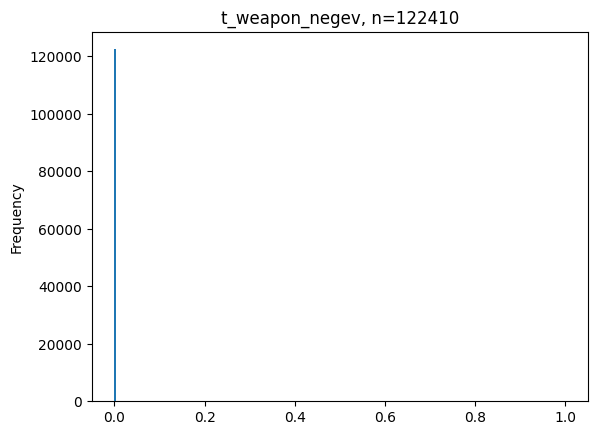

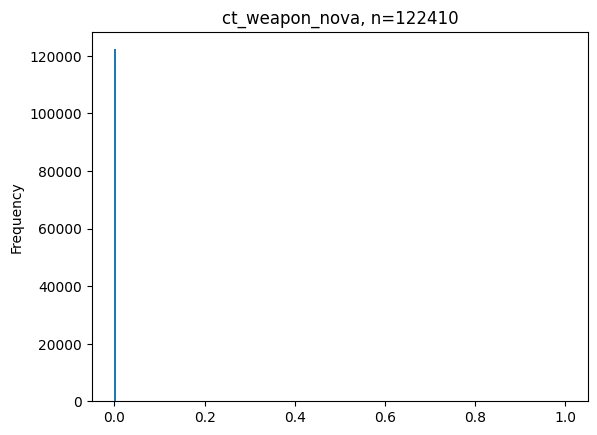

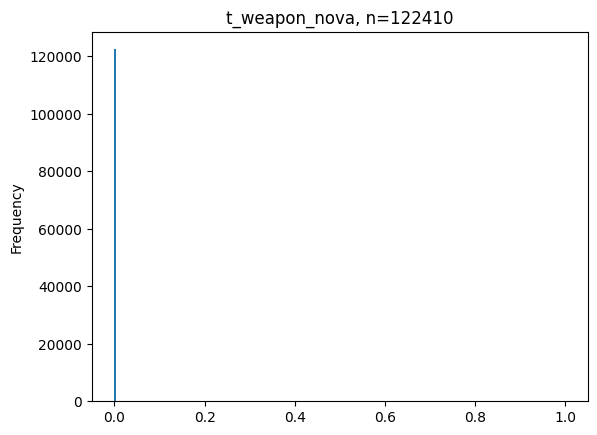

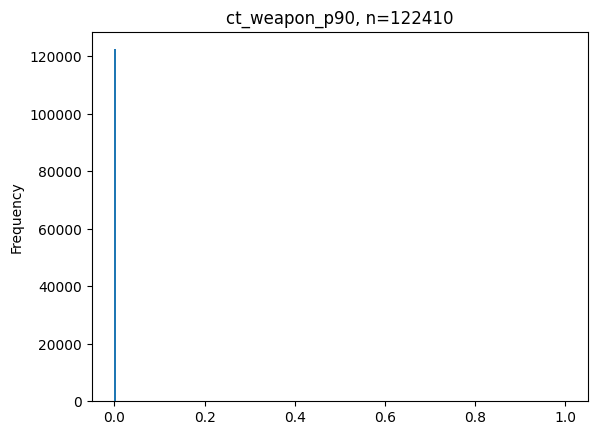

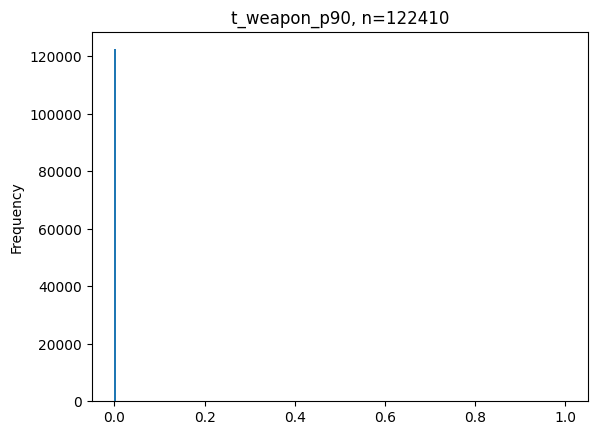

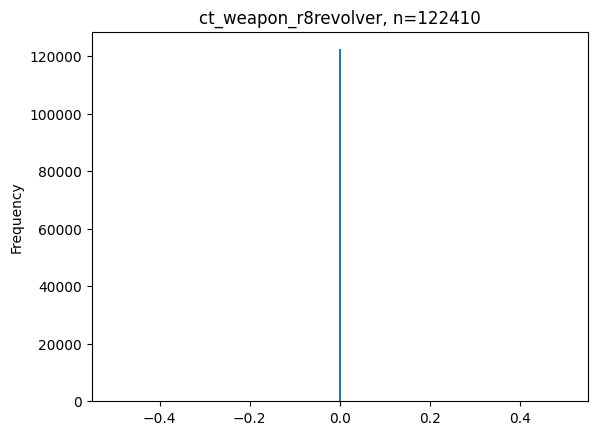

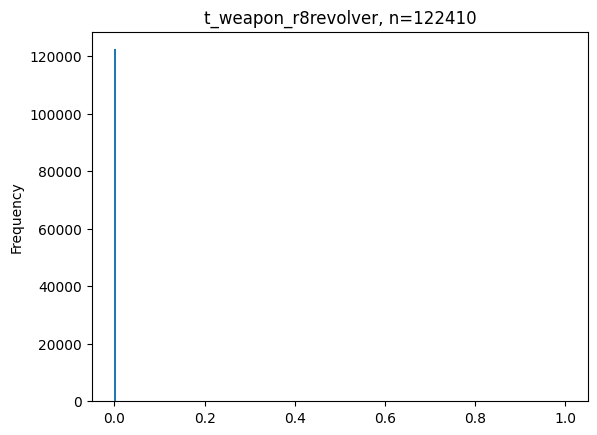

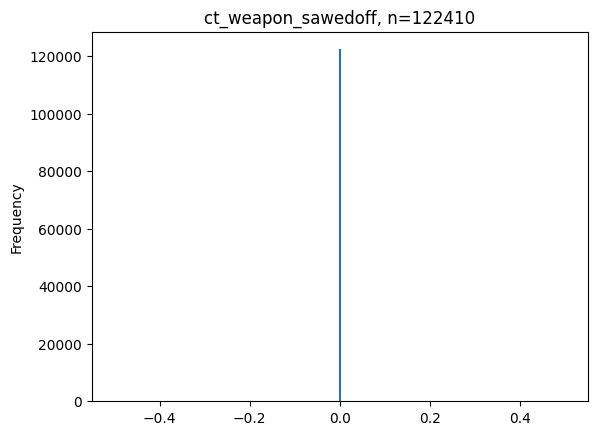

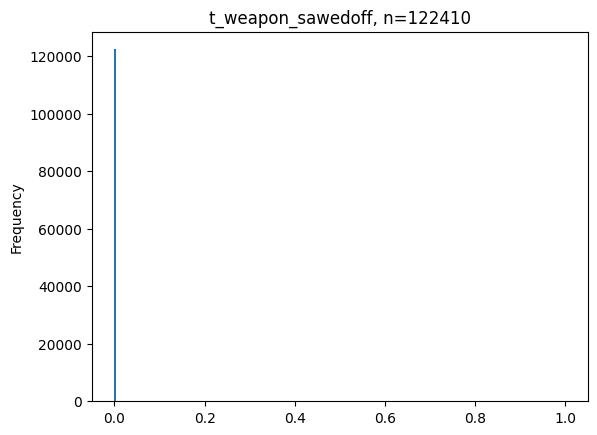

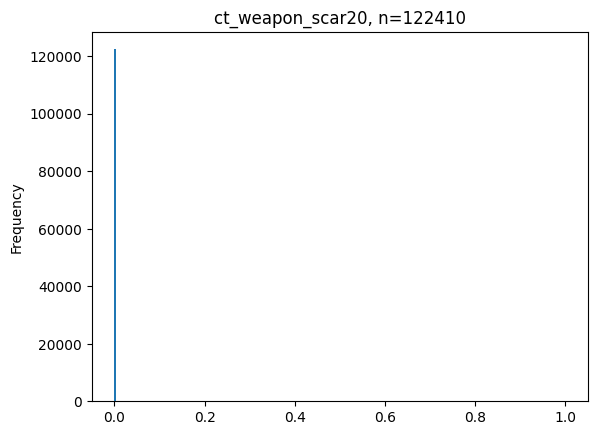

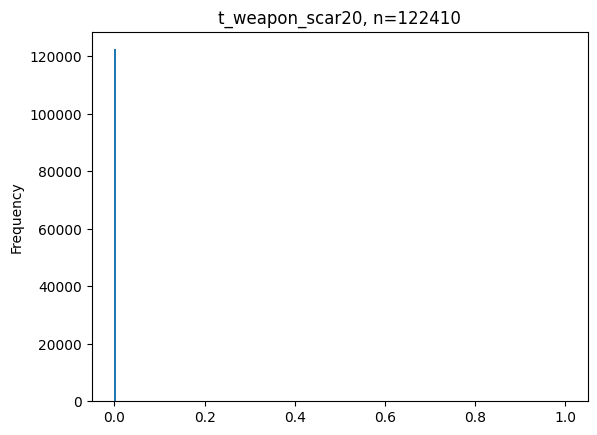

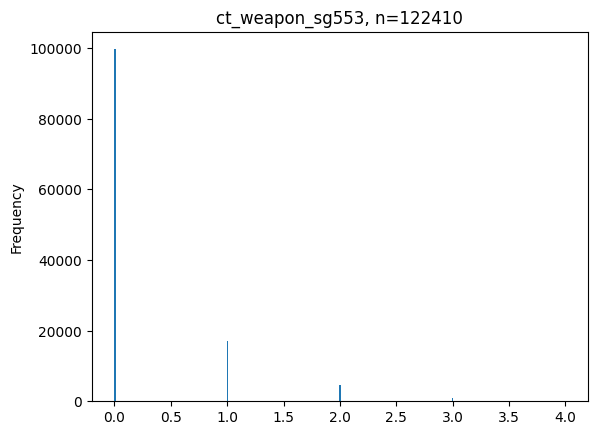

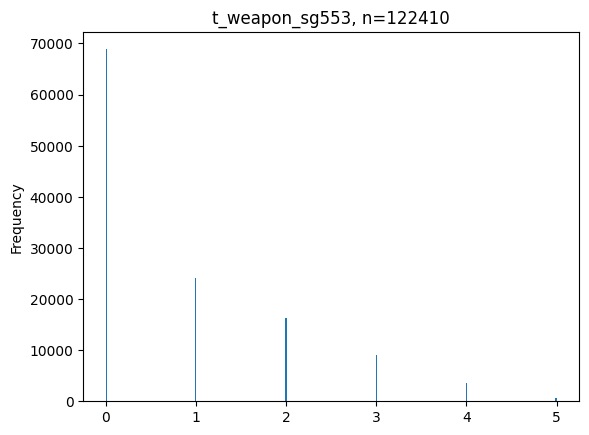

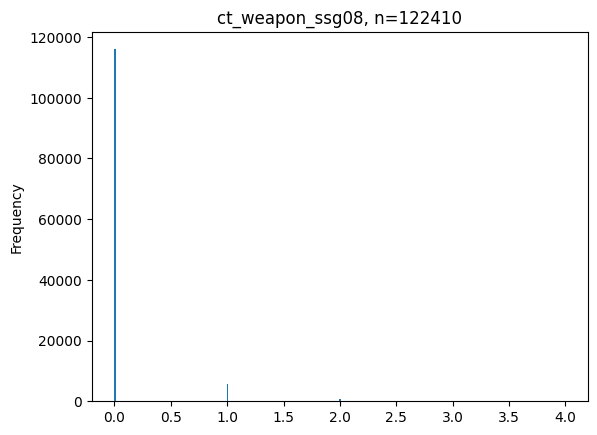

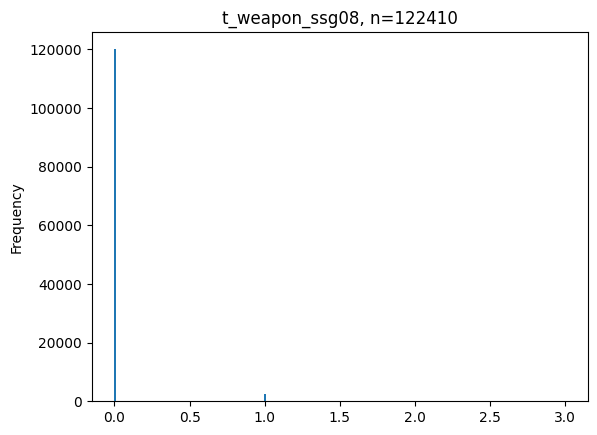

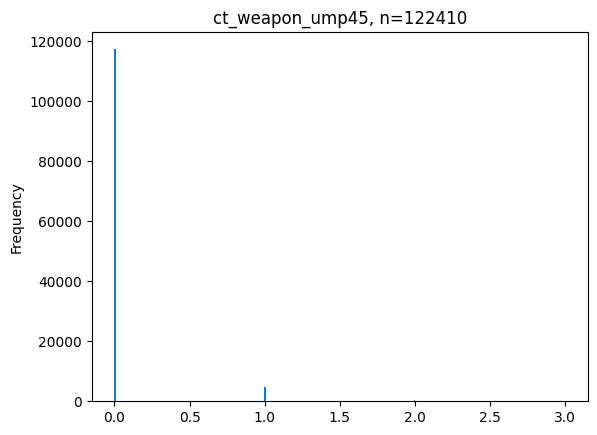

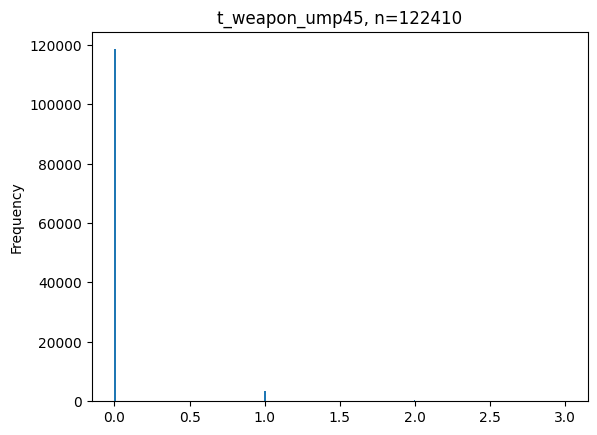

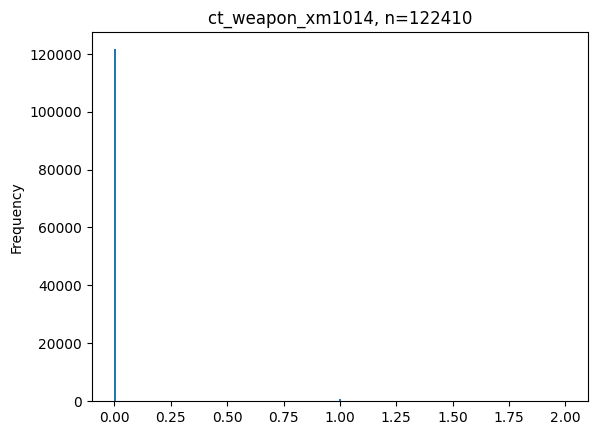

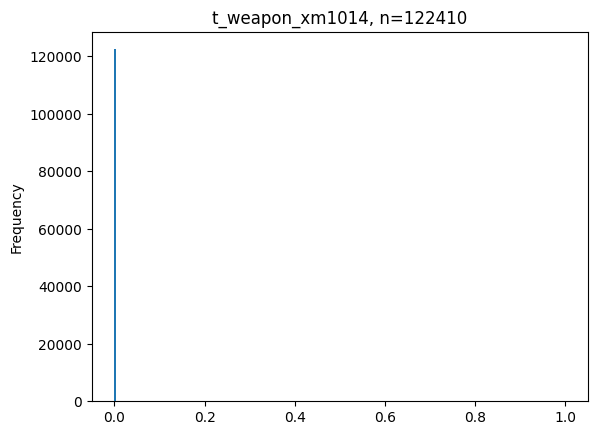

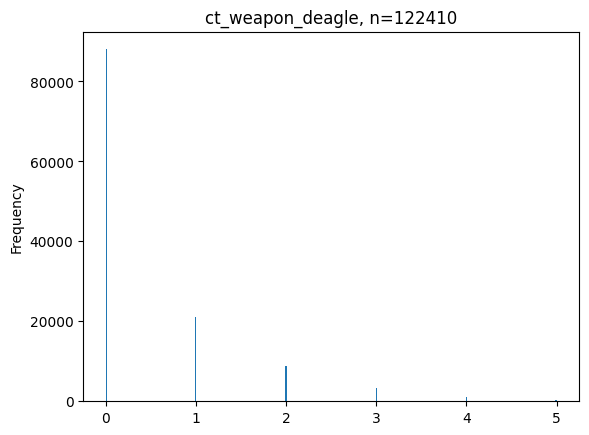

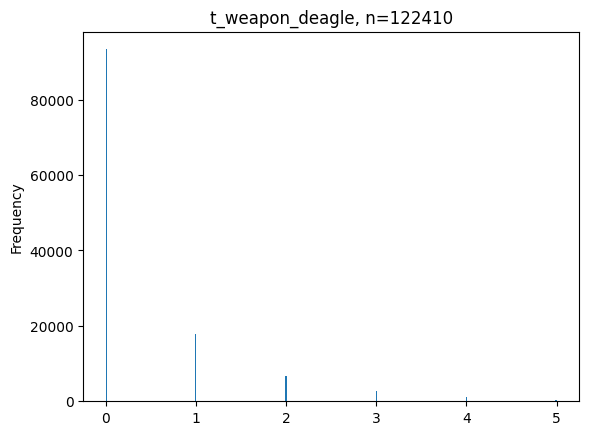

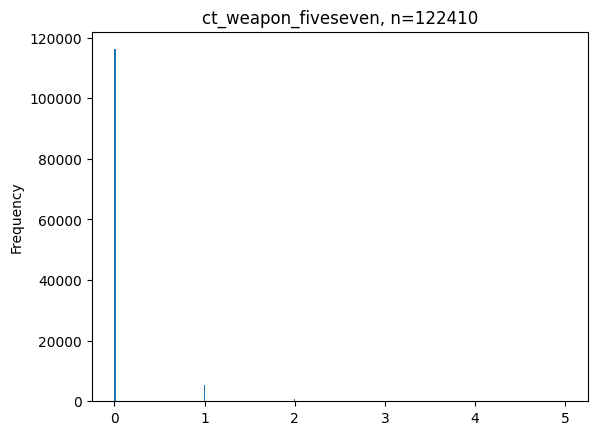

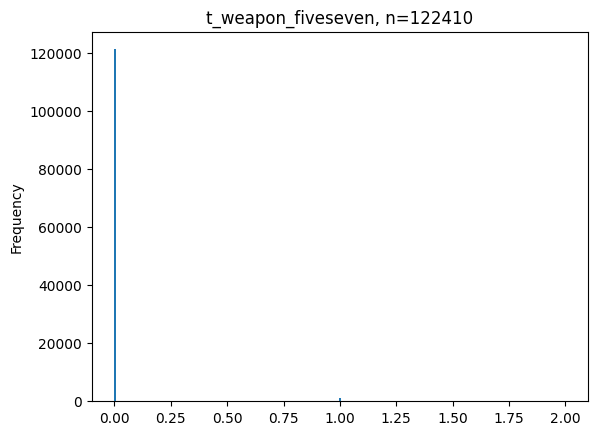

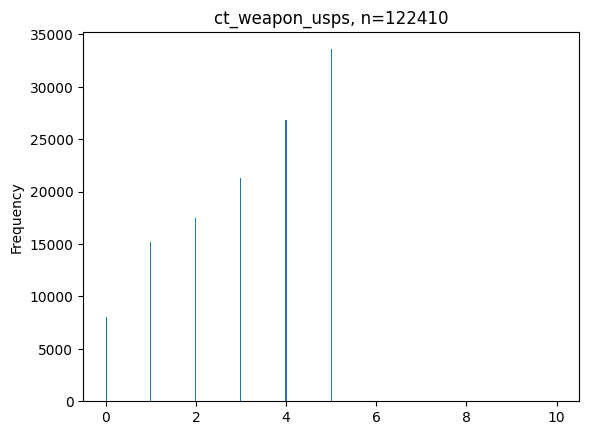

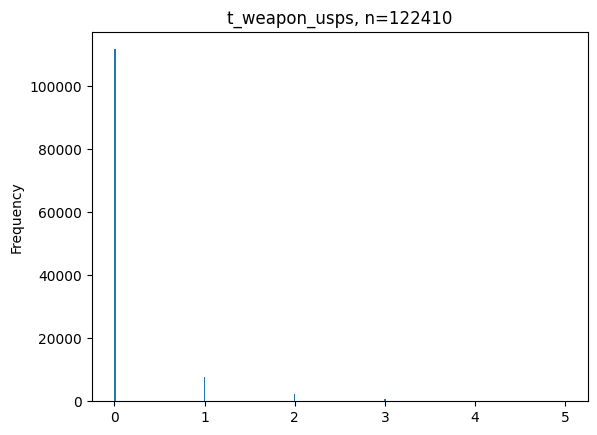

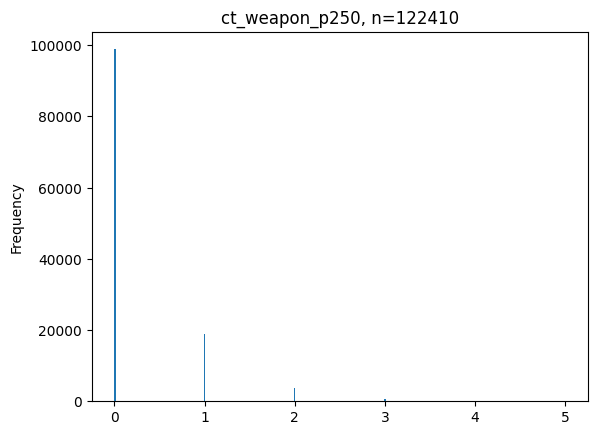

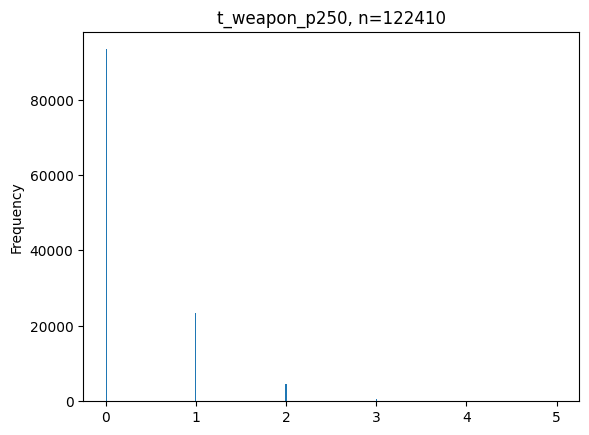

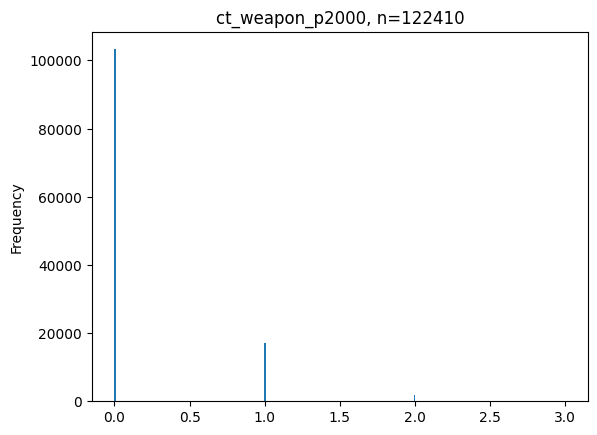

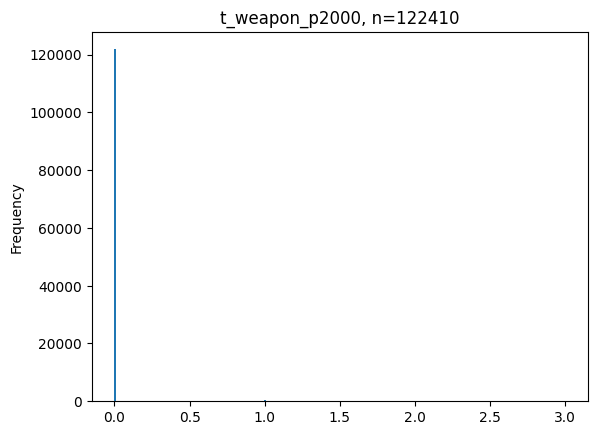

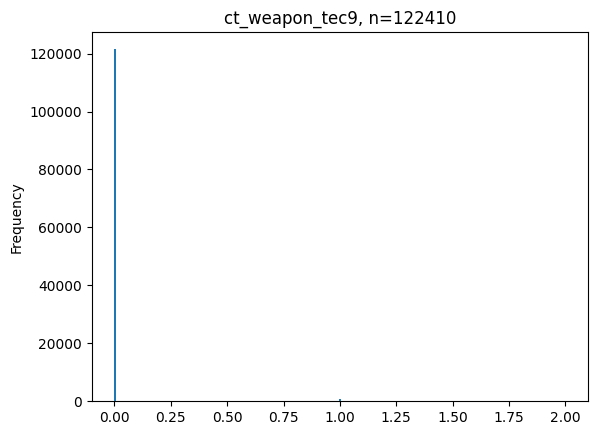

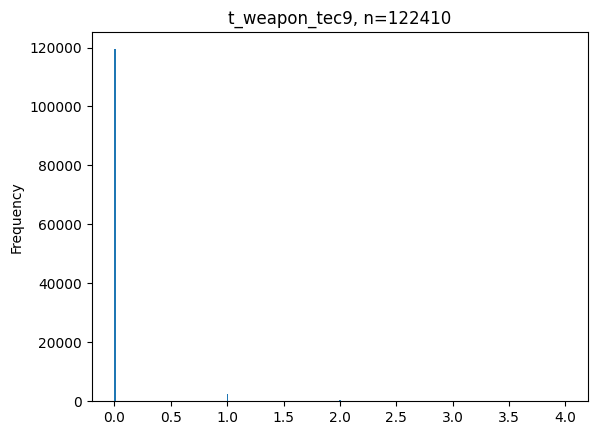

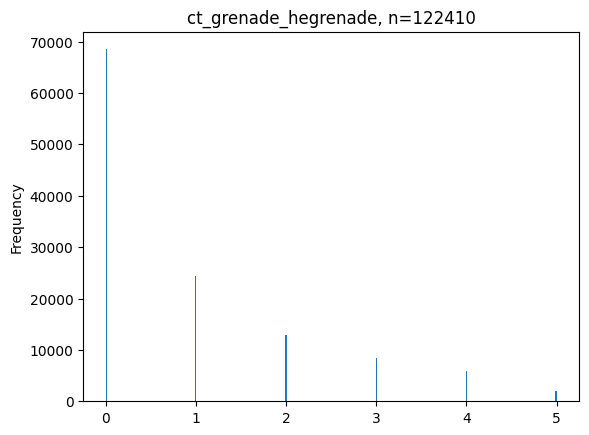

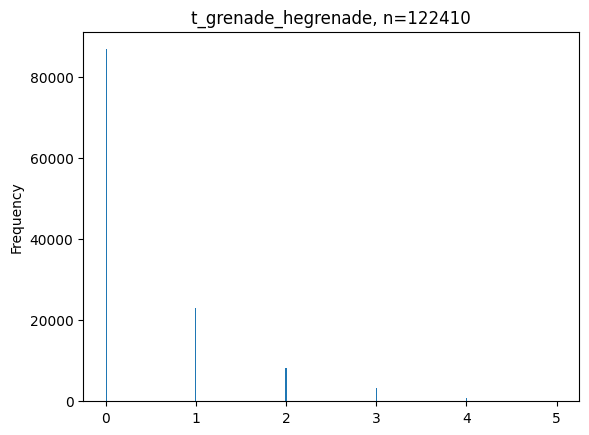

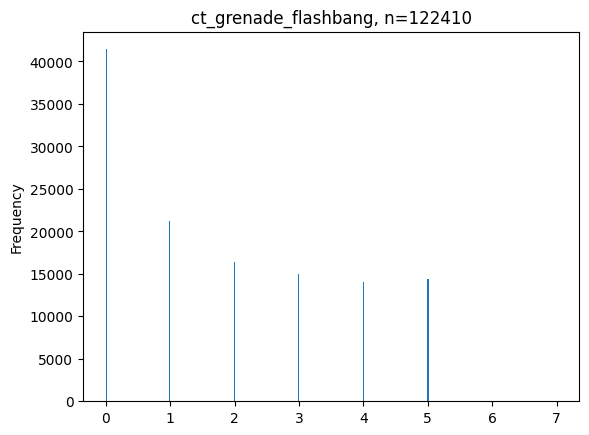

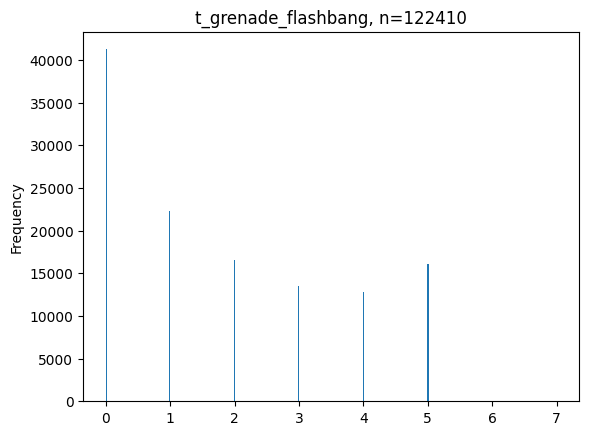

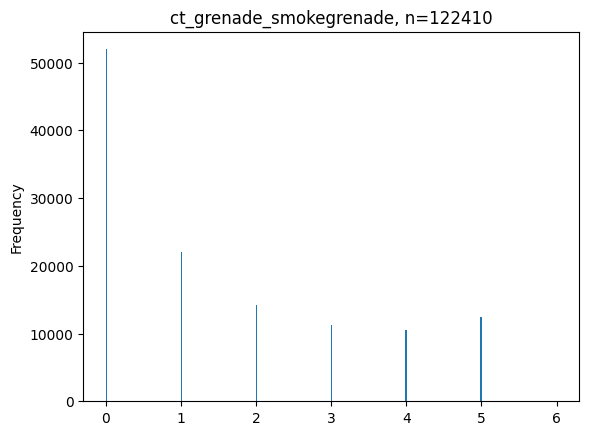

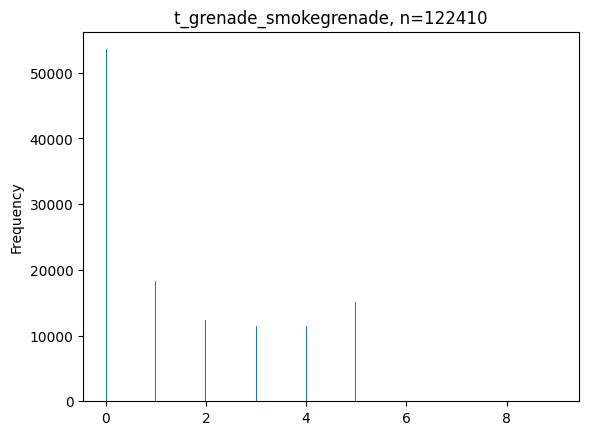

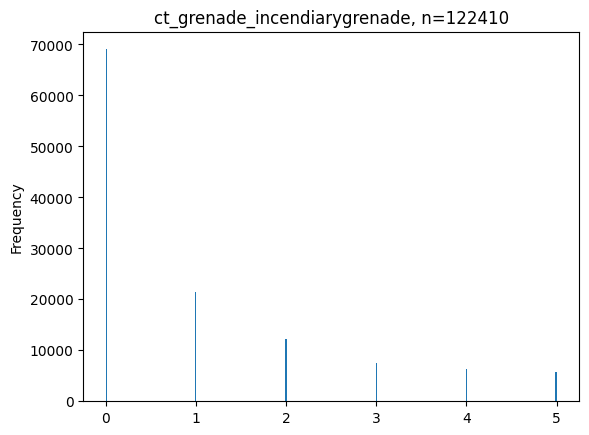

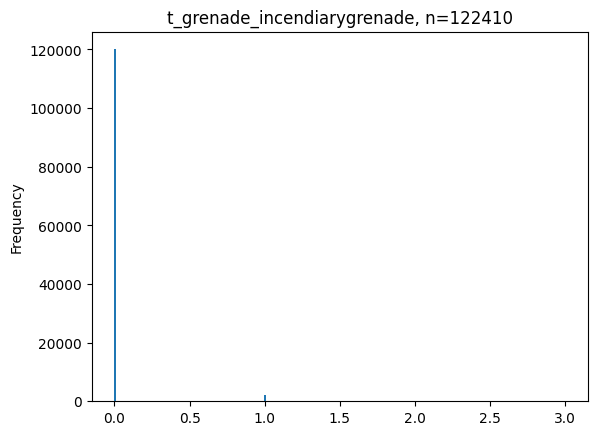

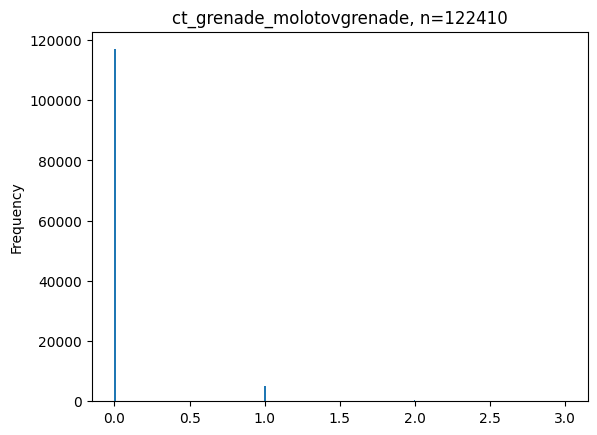

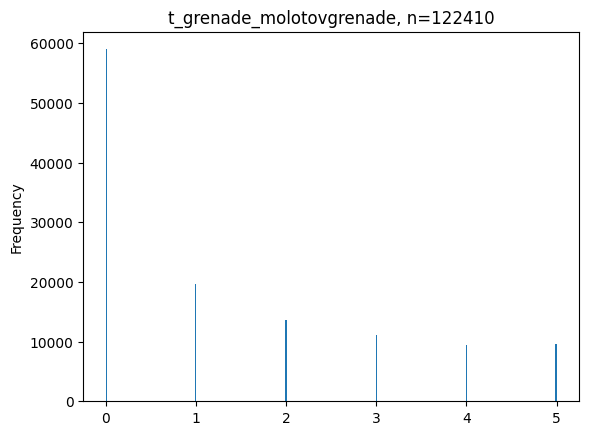

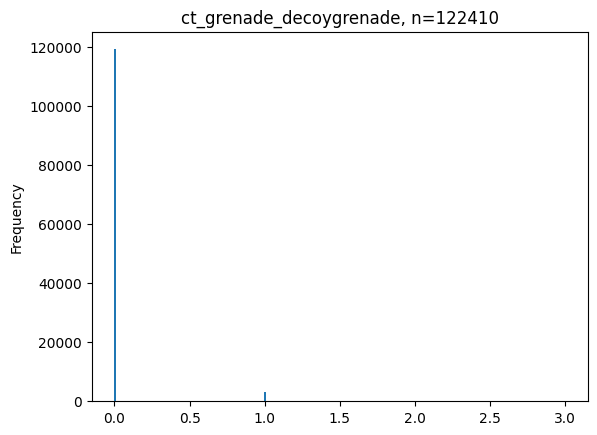

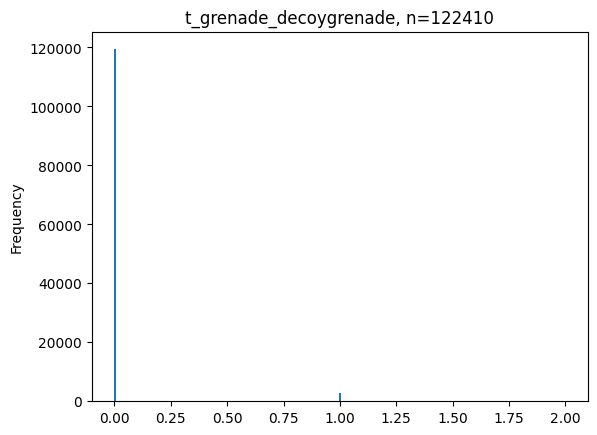

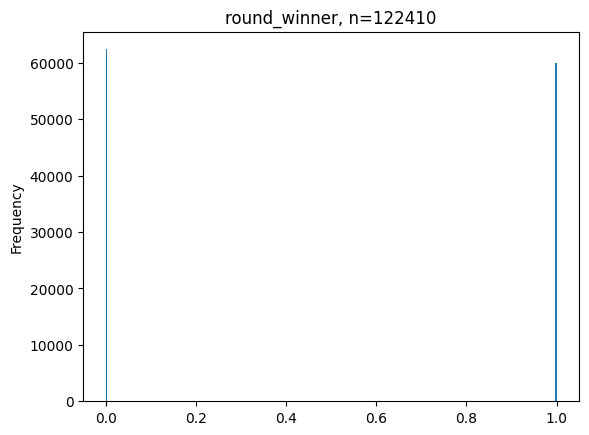

In [9]:
def plot_numericals(data, cols):
    summary = data[cols] \
        .describe() \
        .transpose() \
        .sort_values(by='count')

    print(summary)

    n = data.shape[0]
    b = int(np.sqrt(n))
    for k, (col, val) in enumerate(summary['count'].items()):
        plt.figure()
        data[col].plot.hist(bins=b)
        plt.title(f'{col}, n={int(val)}')
        plt.show()

plot_numericals(data, data.select_dtypes('number').columns)

Here we can see a lot of tendencies, let's break them down:
First, we'll look at the time_left, since the data comes from random snapshots along the game, they are taken mostly in more or less the same time intervals, and getting less often, because the round can end before the time is up.
Then, looking at the ct_score and the t_score, we can see the linearly going down until 16, which is the maximum score in a game of CS:GO, so this is expected. It can go a little more because of overtime, but that doesn't happen as often as going to 16.
After that, when we look at the health and armor, we see that they jump from hundreds to hundreds. Since each of the 5 players can have at most 100 health and 100 armor, they tend to go down 100 by 100, since a player is more often killed between snapshots than just damaged.
Then, we have the most interesting variable in my opinion, money. The money tends to stay mostyly between 0 and 1400, since 1400 is the minimum you can get in a round and 0 because players tend to spend all their money in the round.
The last curious variable to talk about are the weapons/grenades. They tend to stay on 0, since there are a lot of weapons and players can only use one at a time. Then we can clearly see which wepons are the most popular, since they appear way more often than the others. The only exception for this are the t_weapon_glock and ct_weapon_usps, which are the starting weapons for each team, so they are the most common.

Here, we can also see that there are some weapons that are not used frequently. Since every player can choose to buy any weapon, we can see that some weapons that are not that important to the game, because they aren't used often. We can then remove these weapons from the dataset, since they are not relevant for the analysis. So we'll take a look at the weapons that appear less than 500 times in the dataset and remove them. 

From the graph we can see these are the weapons that appear less frequently:
- t_weapon_aug
- ct_weapon_bizon
- t_weapon_bizon
- ct_weapon_elite
- t_weapon_elite
- t_weapon_famas
- ct_weapon_g4sg1
- t_weapon_g4sg1
- ct_weapon_galilar
- ct_weapon_glock
- ct_weapon_m249
- t_weapon_m249
- t_weapon_m4a1s
- ct_weapon_mac10
- ct_weapon_mag7
- t_weapon_mag7
- ct_weapon_mp5sd
- t_weapon_mp5sd
- ct_weapon_mp7
- t_weapon_mp7
- t_weapon_mp9
- ct_weapon_negev
- t_weapon_negev
- ct_weapon_nova
- t_weapon_nova
- ct_weapon_p90
- t_weapon_p90
- ct_weapon_r8revolver
- t_weapon_r8revolver
- ct_weapon_sawedoff
- t_weapon_sawedoff
- ct_weapon_scar20
- t_weapon_scar20
- ct_weapon_xm1014
- t_weapon_xm1014
- t_weapon_fiveseven
- t_weapon_p2000
- ct_weapon_tec9
- t_grenade_incendiarygrenade
- ct_grenade_molotovgrenade
- ct_grenade_decoygrenade
- t_grenade_decoygrenade

In [26]:
for x in data:
    if 'weapon' in x or 'grenade' in x:
        total = 0
        for n in range(3):
            if n != 0:
                try:
                    total += data[x].value_counts()[n]
                except KeyError:
                    pass
        if total < 500:
            print(f'{x}: {total}')
            data = data.drop(columns=[x])

ct_weapon_bizon: 0
t_weapon_bizon: 10
ct_weapon_elite: 491
t_weapon_elite: 217
ct_weapon_g3sg1: 0
t_weapon_g3sg1: 63
ct_weapon_m249: 1
t_weapon_m249: 0
t_weapon_m4a1s: 328
t_weapon_mag7: 6
ct_weapon_mp5sd: 179
t_weapon_mp5sd: 324
ct_weapon_mp7: 245
t_weapon_mp7: 236
ct_weapon_negev: 0
t_weapon_negev: 1
ct_weapon_nova: 120
t_weapon_nova: 13
ct_weapon_p90: 20
t_weapon_p90: 19
ct_weapon_r8revolver: 0
t_weapon_r8revolver: 7
ct_weapon_sawedoff: 0
t_weapon_sawedoff: 17
ct_weapon_scar20: 88
t_weapon_scar20: 1
t_weapon_xm1014: 32


We can see that all of these weapons appear less than 500 times in the dataset, so we can remove them from the dataset. We can confirm that they appear less in the graph as well.

In [28]:
data.describe()

time_left       ct_score        t_score      ct_health  \
count  122410.000000  122410.000000  122410.000000  122410.000000   
mean       97.886922       6.709239       6.780435     412.106568   
std        54.465238       4.790362       4.823543     132.293290   
min         0.010000       0.000000       0.000000       0.000000   
25%        54.920000       3.000000       3.000000     350.000000   
50%        94.910000       6.000000       6.000000     500.000000   
75%       166.917500      10.000000      10.000000     500.000000   
max       175.000000      32.000000      33.000000     500.000000   

            t_health       ct_armor        t_armor       ct_money  \
count  122410.000000  122410.000000  122410.000000  122410.000000   
mean      402.714500     314.142121     298.444670    9789.023773   
std       139.919033     171.029736     174.576545   11215.042286   
min         0.000000       0.000000       0.000000       0.000000   
25%       322.000000     194.000000     174.000000    1300.000000   
50%       500.000000     377.000000     334.000000    5500.000000   
75%       500.000000     486.000000     468.000000   14600.000000   
max       600.000000     500.000000     500.000000   80000.000000   

             t_money     ct_helmets  ...  t_grenade_flashbang  \
count  122410.000000  122410.000000  ...        122410.000000   
mean    11241.036680       2.053901  ...             1.858100   
std     12162.806759       1.841470  ...             1.794473   
min         0.000000       0.000000  ...             0.000000   
25%      1550.000000       0.000000  ...             0.000000   
50%      7150.000000       2.000000  ...             1.000000   
75%     18000.000000       4.000000  ...             3.000000   
max     80000.000000       5.000000  ...             7.000000   

       ct_grenade_smokegrenade  t_grenade_smokegrenade  \
count            122410.000000           122410.000000   
mean                  1.540814                1.627146   
std                   1.737804                1.829147   
min                   0.000000                0.000000   
25%                   0.000000                0.000000   
50%                   1.000000                1.000000   
75%                   3.000000                3.000000   
max                   6.000000                9.000000   

       ct_grenade_incendiarygrenade  t_grenade_incendiarygrenade  \
count                 122410.000000                122410.000000   
mean                       1.001969                     0.019819   
std                        1.458084                     0.143933   
min                        0.000000                     0.000000   
25%                        0.000000                     0.000000   
50%                        0.000000                     0.000000   
75%                        2.000000                     0.000000   
max                        5.000000                     3.000000   

       ct_grenade_molotovgrenade  t_grenade_molotovgrenade  \
count              122410.000000             122410.000000   
mean                    0.048011                  1.352095   
std                     0.227669                  1.663246   
min                     0.000000                  0.000000   
25%                     0.000000                  0.000000   
50%                     0.000000                  1.000000   
75%                     0.000000                  2.000000   
max                     3.000000                  5.000000   

       ct_grenade_decoygrenade  t_grenade_decoygrenade   round_winner  
count            122410.000000           122410.000000  122410.000000  
mean                  0.027694                0.025750       0.490189  
std                   0.169531                0.164162       0.499906  
min                   0.000000                0.000000       0.000000  
25%                   0.000000                0.000000       0.000000  
50%                   0.000000                0.000000

## Viewing the clean data

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 70 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   time_left                     122410 non-null  float64 
 1   ct_score                      122410 non-null  float64 
 2   t_score                       122410 non-null  float64 
 3   map                           122410 non-null  category
 4   bomb_planted                  122410 non-null  bool    
 5   ct_health                     122410 non-null  float64 
 6   t_health                      122410 non-null  float64 
 7   ct_armor                      122410 non-null  float64 
 8   t_armor                       122410 non-null  float64 
 9   ct_money                      122410 non-null  float64 
 10  t_money                       122410 non-null  float64 
 11  ct_helmets                    122410 non-null  float64 
 12  t_helmets                     

In [30]:
numerical_data = data.select_dtypes('number').drop(columns='round_winner').copy()
target = data['round_winner'].copy()

In [47]:
print(numerical_data.corrwith(target).filter(regex='^ct_').sort_values(ascending=False))

ct_armor                        0.336382
ct_helmets                      0.308255
ct_defuse_kits                  0.291557
ct_grenade_flashbang            0.253868
ct_players_alive                0.216798
ct_grenade_smokegrenade         0.209975
ct_weapon_awp                   0.198626
ct_health                       0.190662
ct_weapon_m4a4                  0.178008
ct_grenade_hegrenade            0.168781
ct_grenade_incendiarygrenade    0.168517
ct_weapon_ak47                  0.166855
ct_weapon_sg553                 0.163963
ct_weapon_usps                  0.152893
ct_money                        0.129326
ct_weapon_aug                   0.080578
ct_grenade_molotovgrenade       0.079758
ct_weapon_mp9                   0.064231
ct_score                        0.057304
ct_weapon_famas                 0.049922
ct_weapon_p250                  0.049614
ct_weapon_m4a1s                 0.047719
ct_weapon_tec9                  0.042672
ct_weapon_galilar               0.035162
ct_weapon_ump45 

In [46]:
# Inverse because T is 0 
print(-numerical_data.corrwith(target).filter(regex='^t_').sort_values())

t_helmets                      0.297458
t_armor                        0.290753
t_weapon_ak47                  0.194147
t_grenade_flashbang            0.166839
t_weapon_sg553                 0.163709
t_weapon_awp                   0.149878
t_players_alive                0.142518
t_grenade_smokegrenade         0.140348
t_weapon_usps                  0.136694
t_grenade_molotovgrenade       0.116754
t_grenade_hegrenade            0.116336
t_money                        0.098362
t_health                       0.091361
t_weapon_m4a4                  0.088002
t_weapon_mac10                 0.087114
t_weapon_glock                 0.069004
t_weapon_ump45                 0.067326
t_weapon_galilar               0.062742
t_grenade_incendiarygrenade    0.050546
t_weapon_p250                  0.045456
t_weapon_fiveseven             0.037264
t_weapon_p2000                 0.036279
t_weapon_famas                 0.035858
t_weapon_aug                   0.031507
t_score                        0.026863


Here we can also se a lot, weapons that are cheaper and used more frequently in rounds where the team is spending less money, tend to correlate with the team losing the round, probably because they have worse weapons. We can also see that the most important factor is helmets and armor, probably because they are the most essential thing to buy in every round, since they protect the player from being killed by a headshot and increase the player's overall survivability.

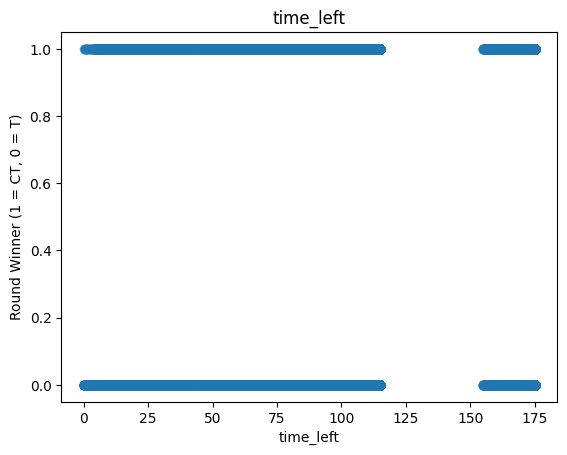

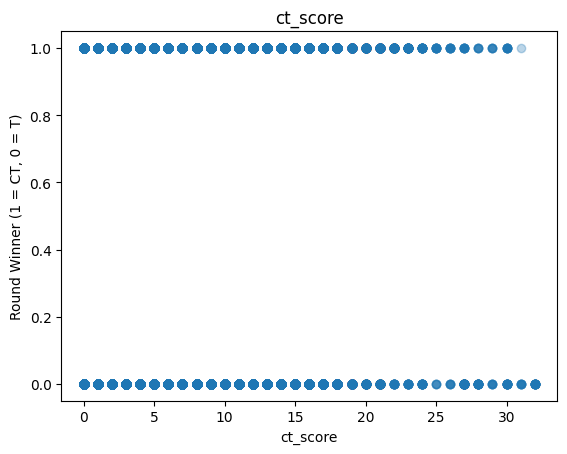

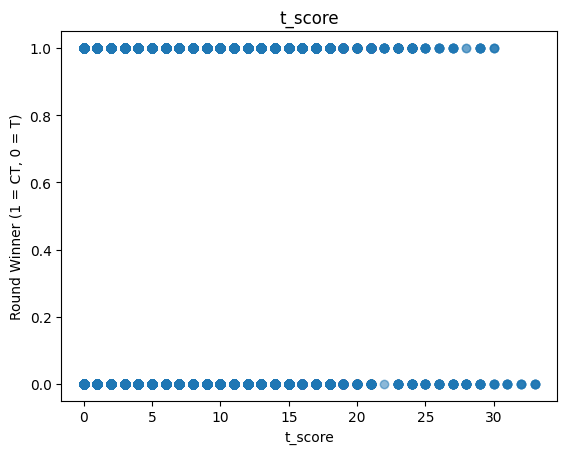

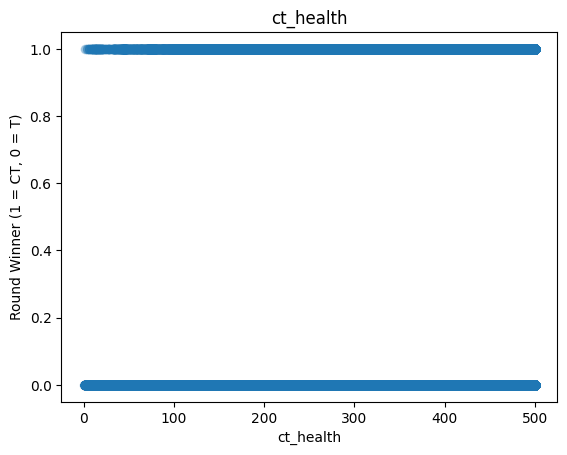

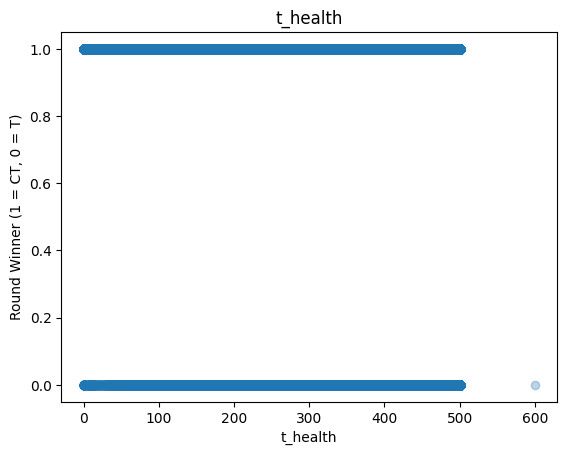

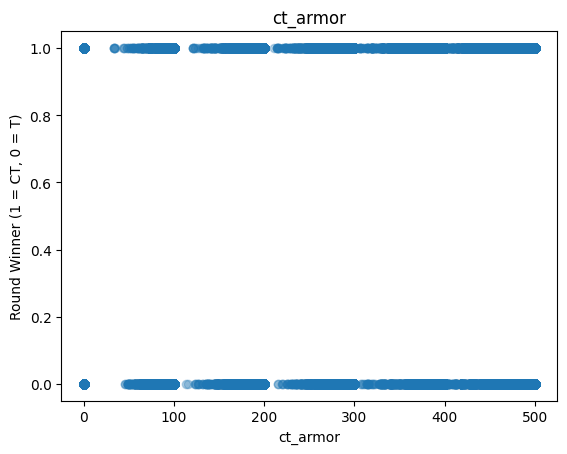

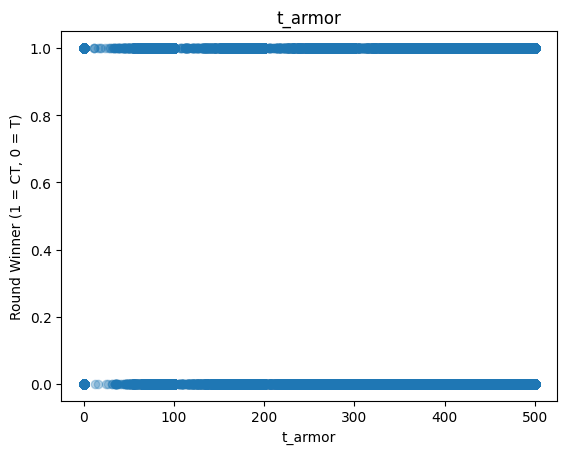

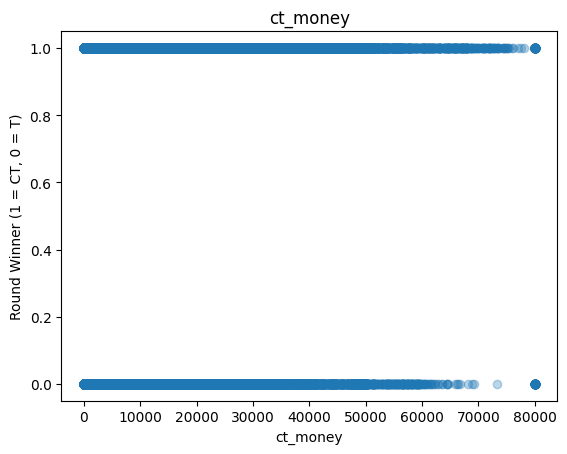

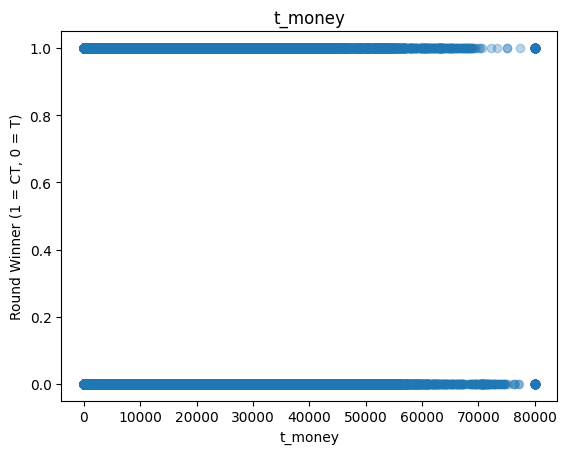

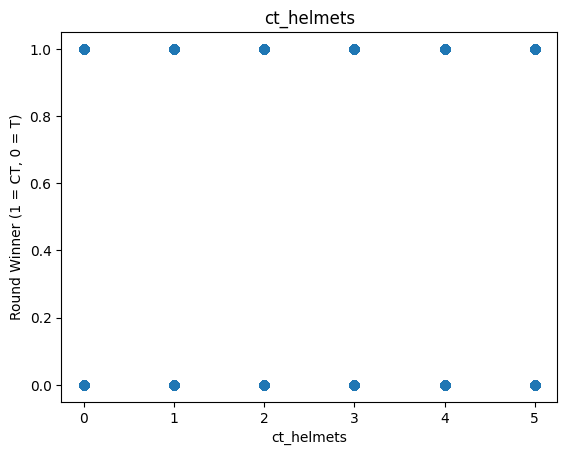

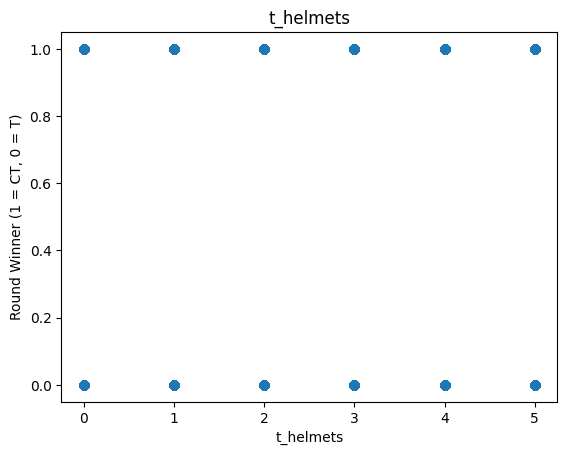

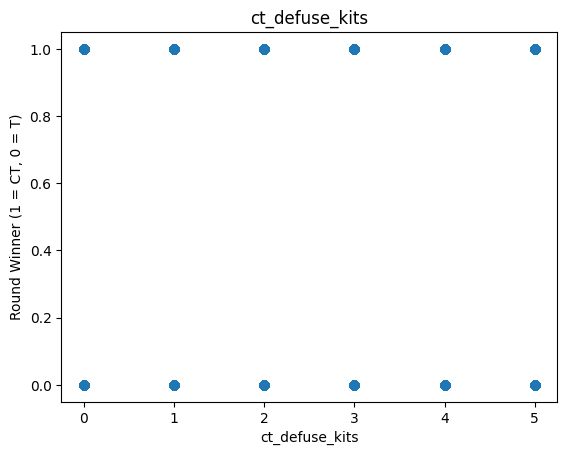

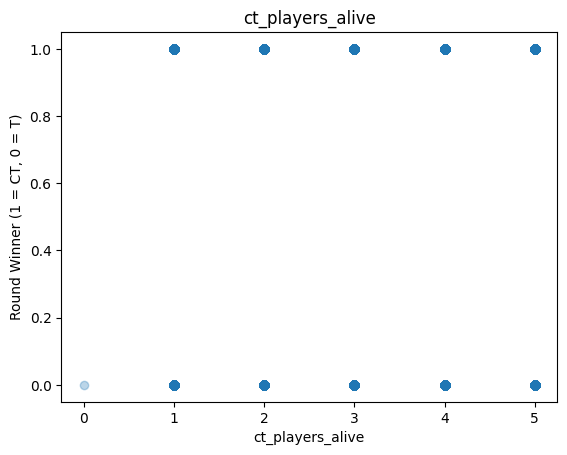

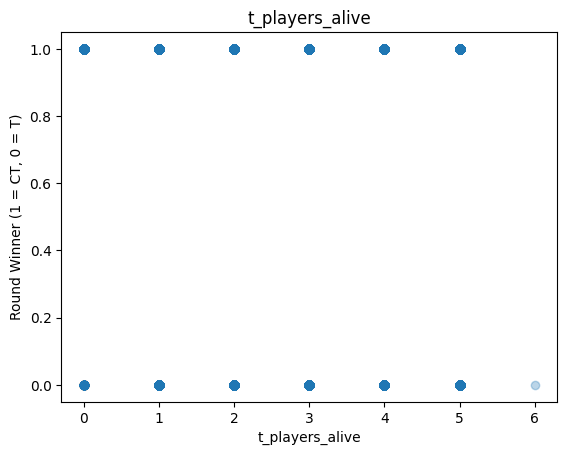

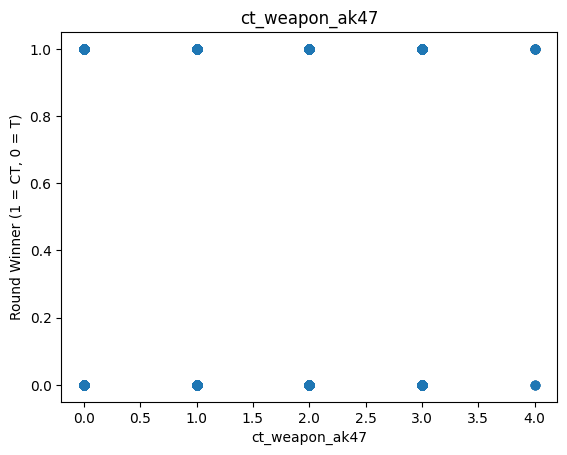

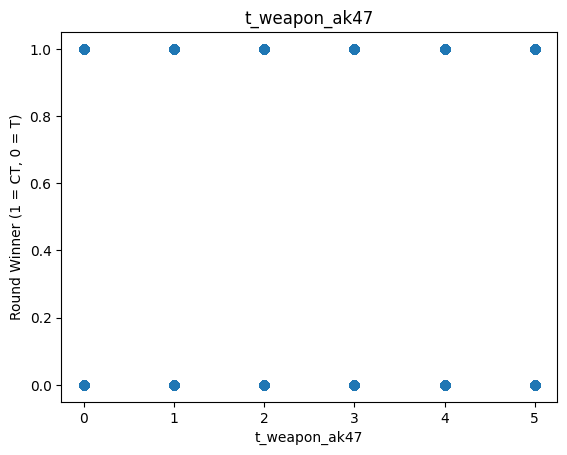

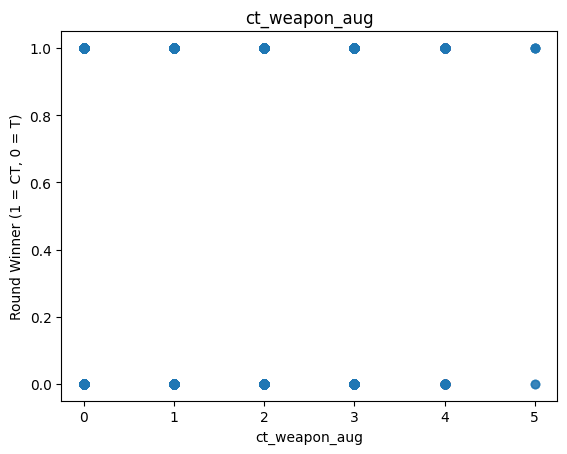

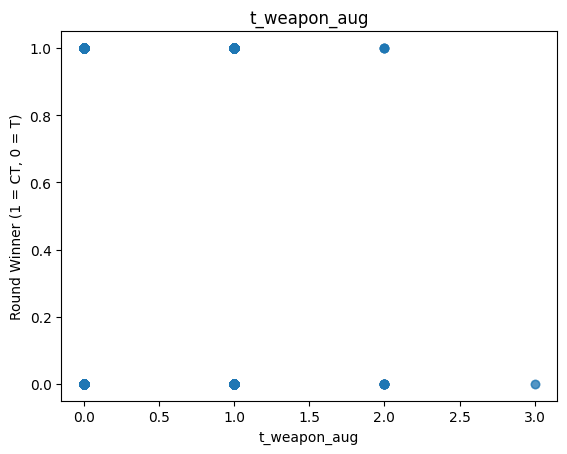

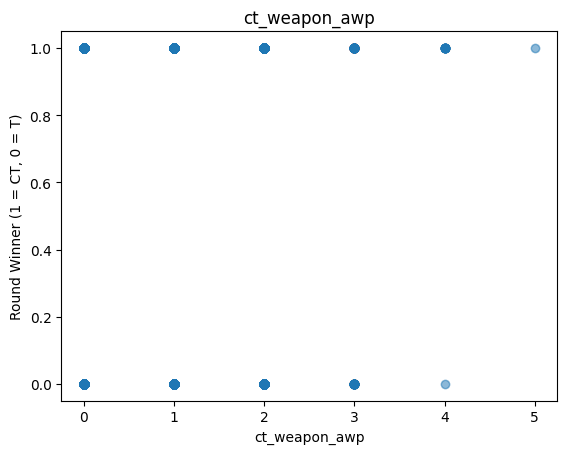

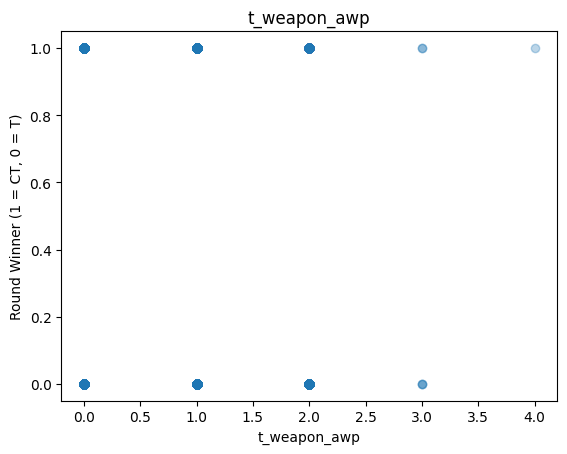

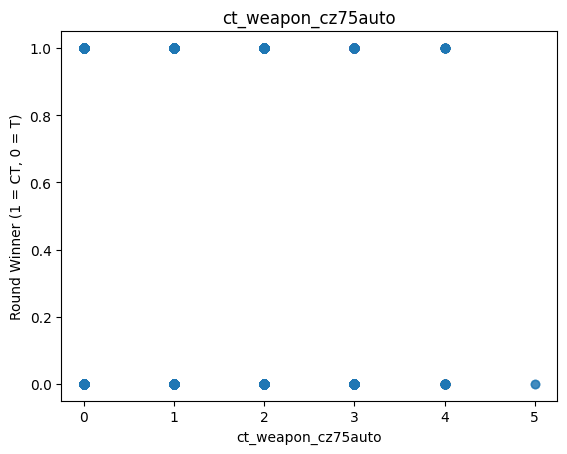

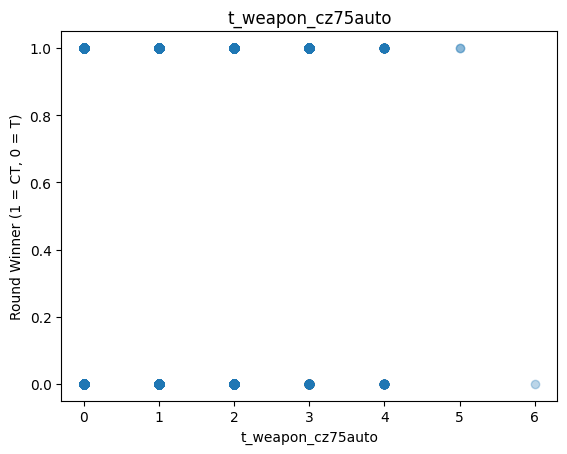

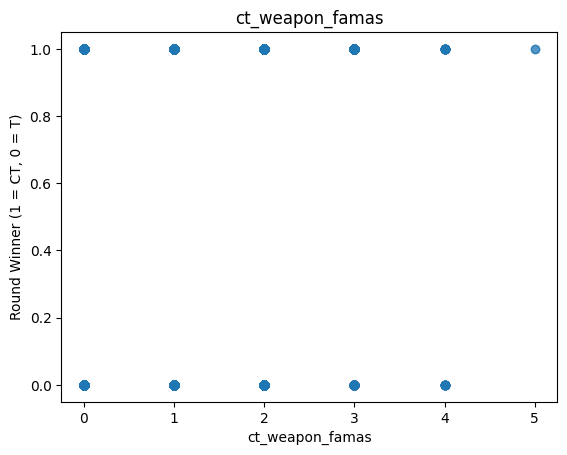

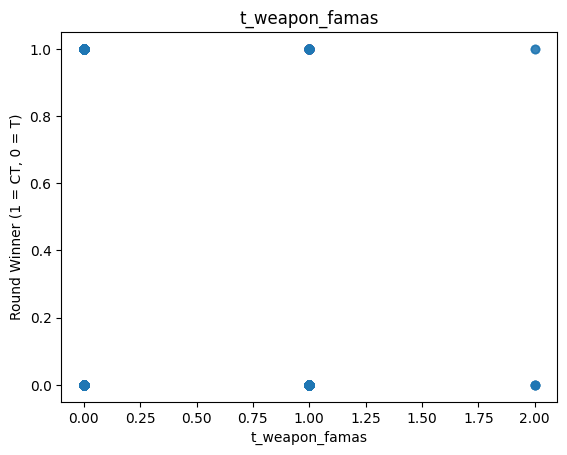

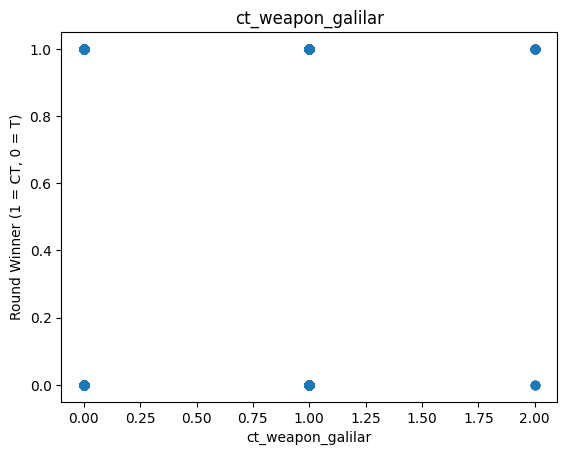

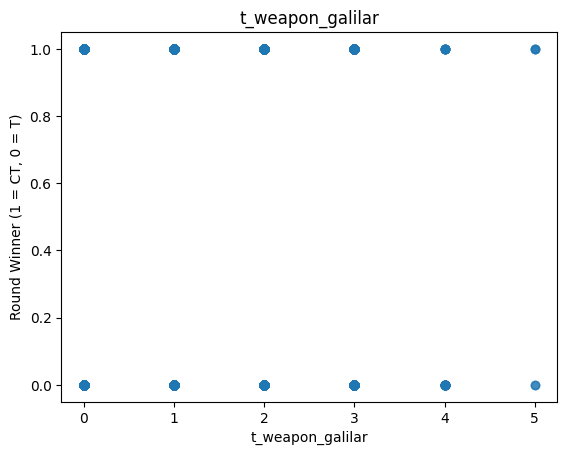

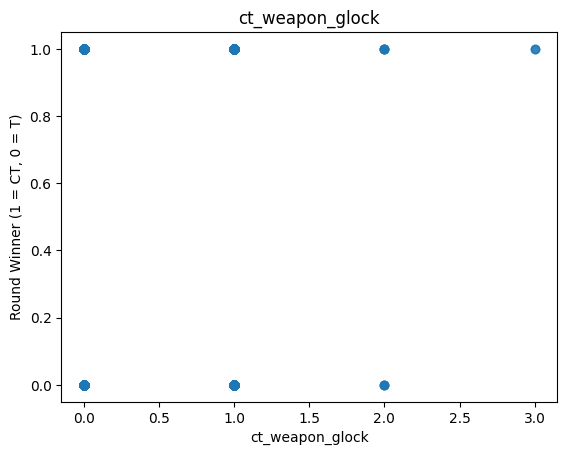

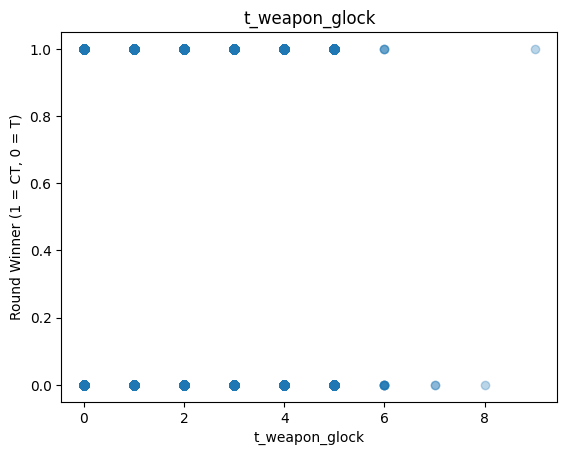

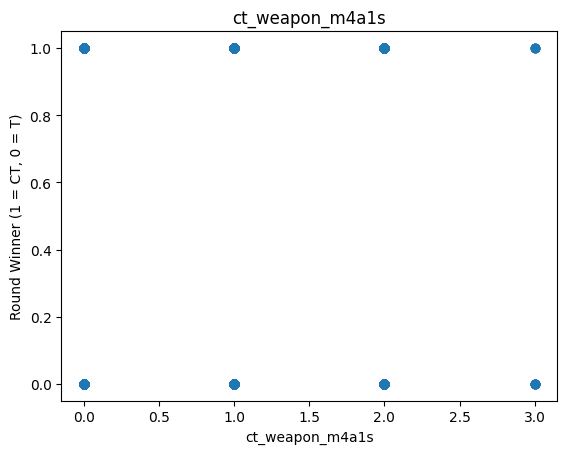

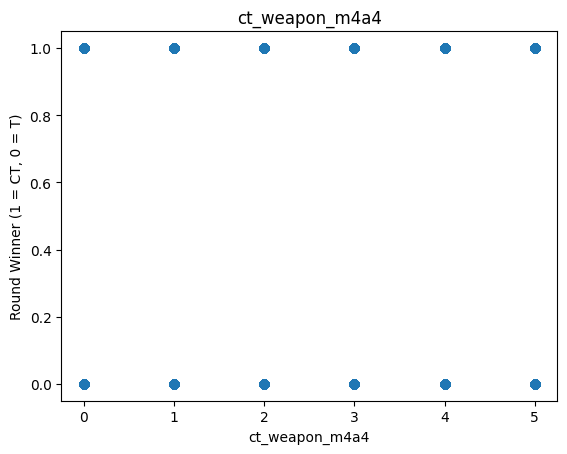

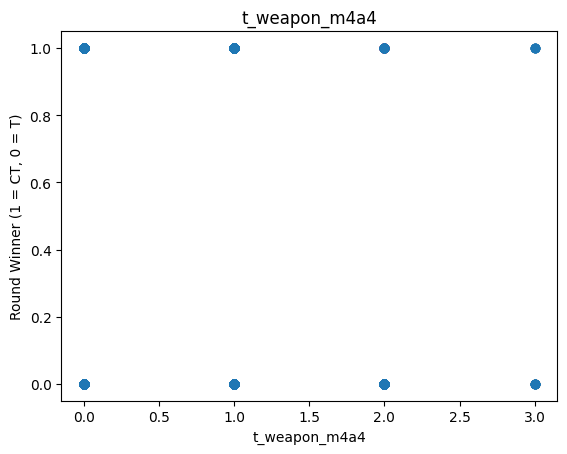

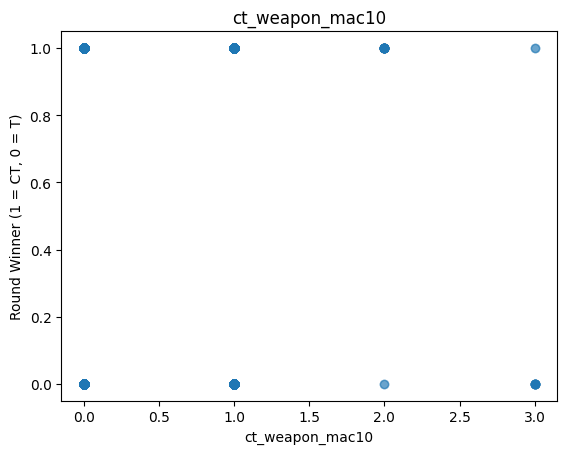

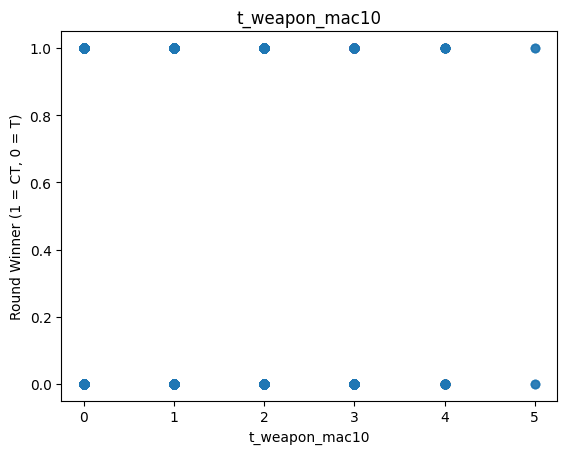

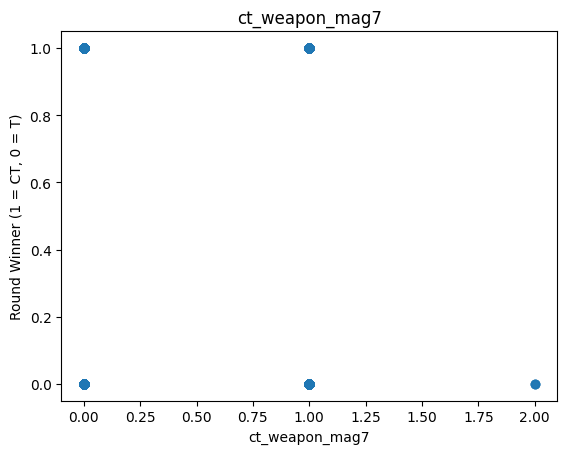

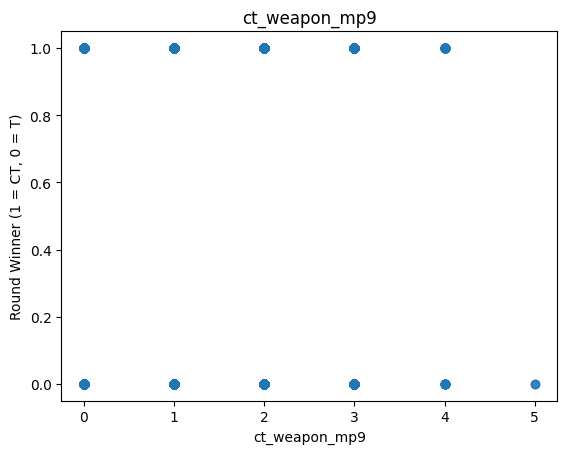

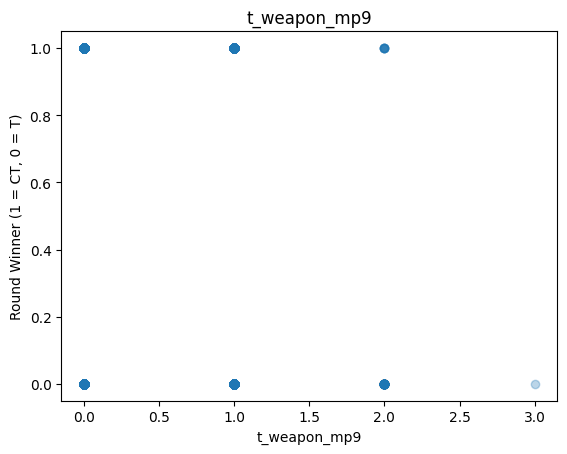

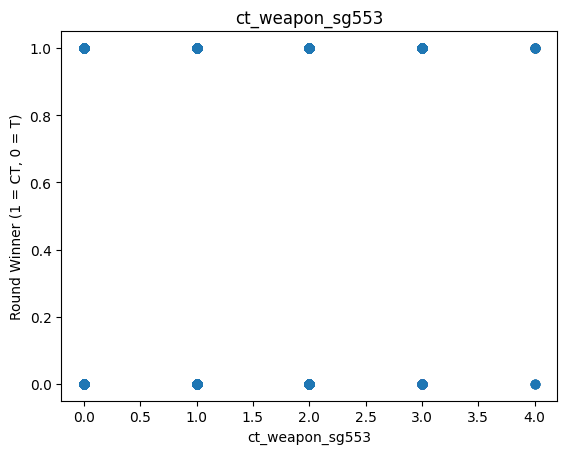

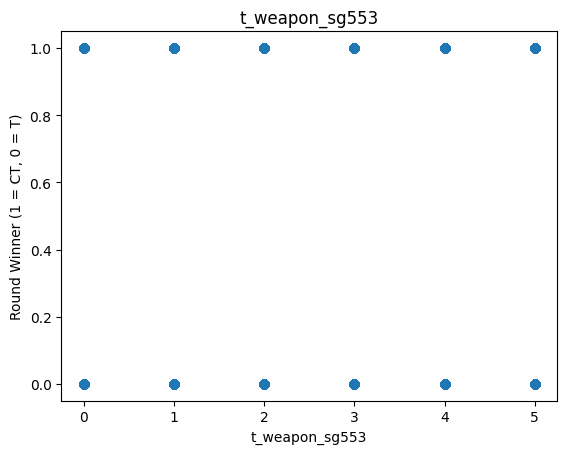

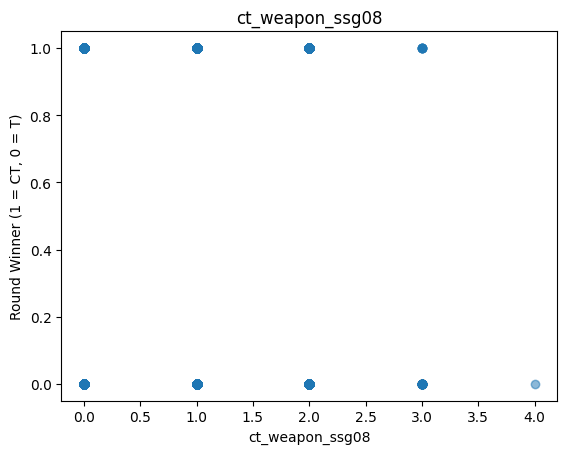

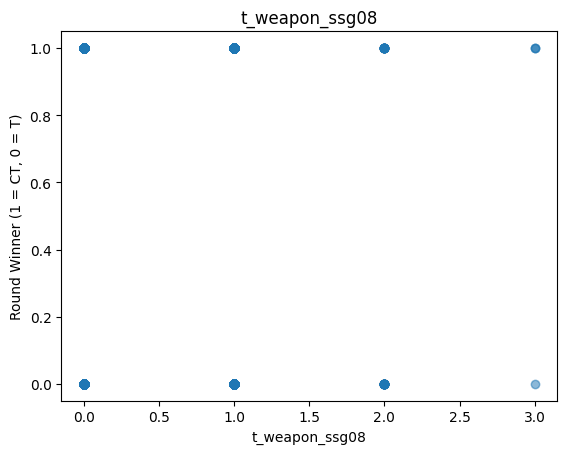

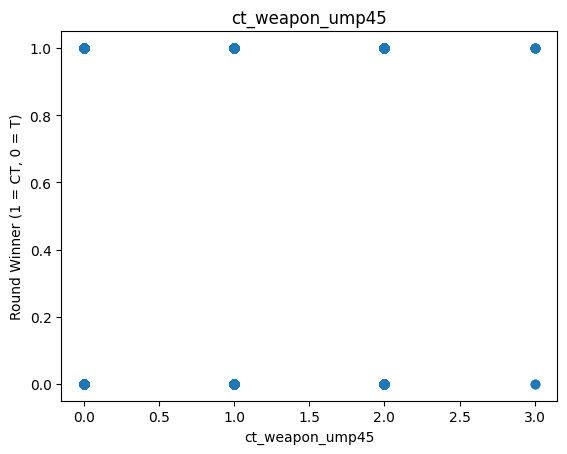

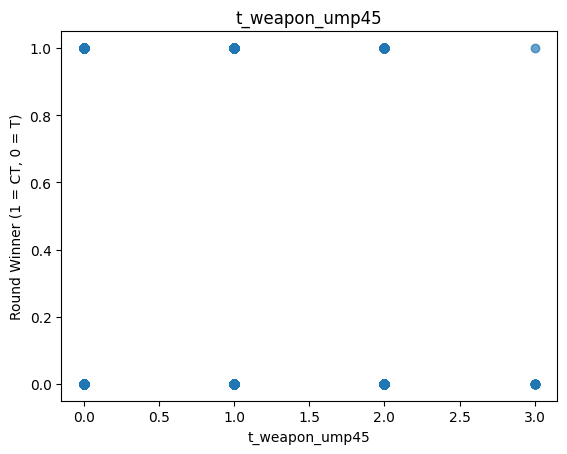

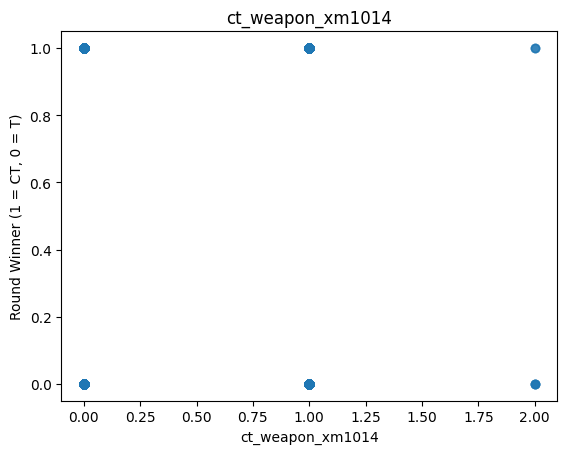

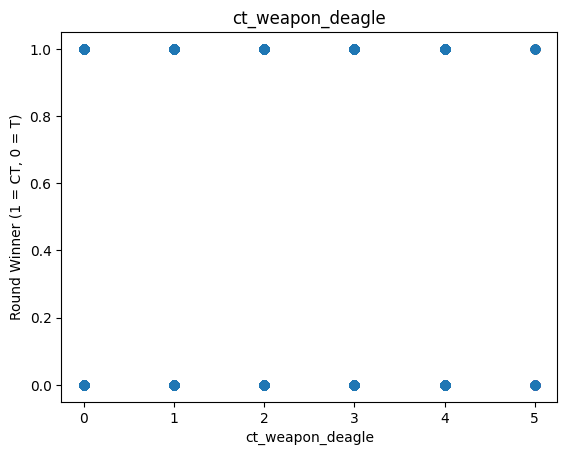

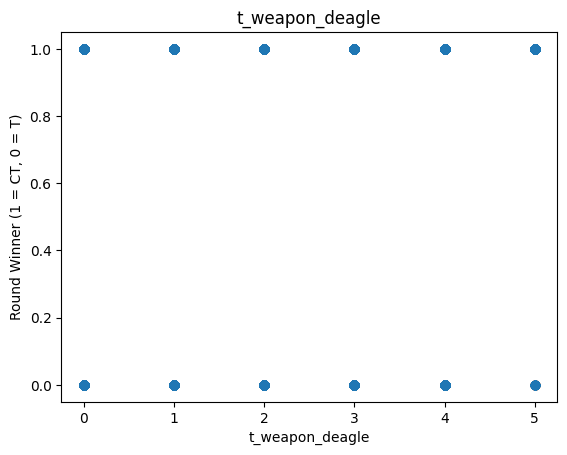

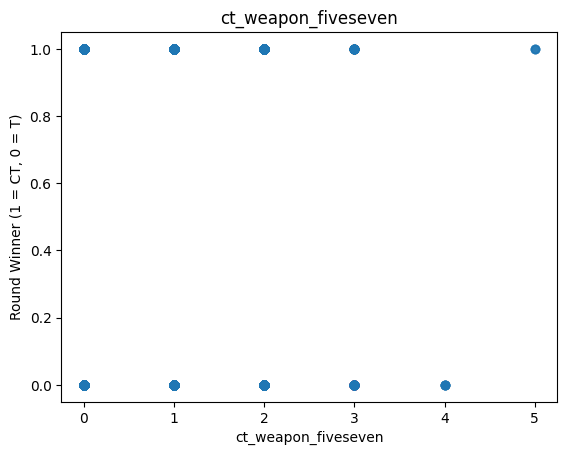

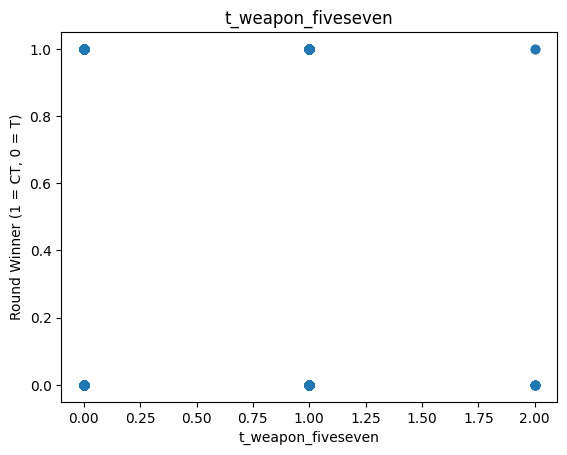

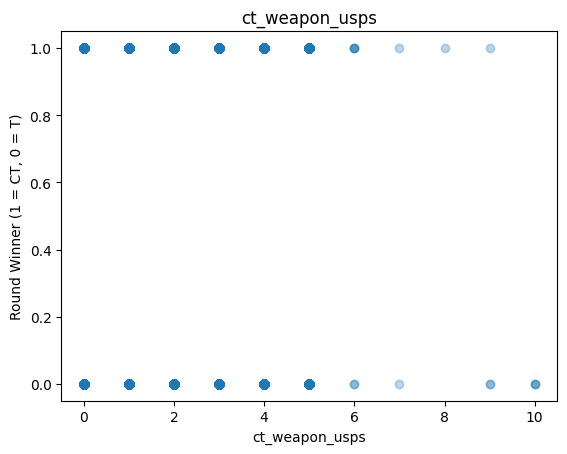

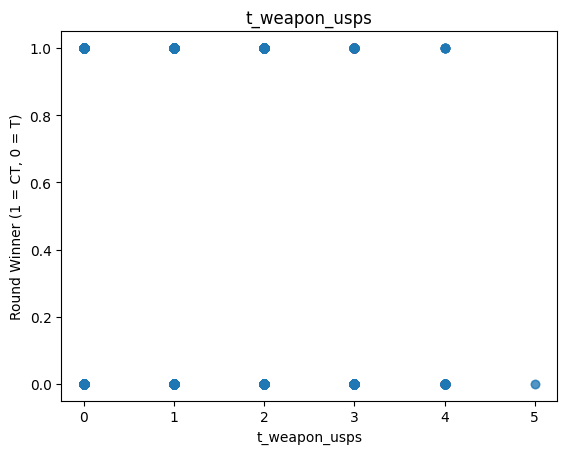

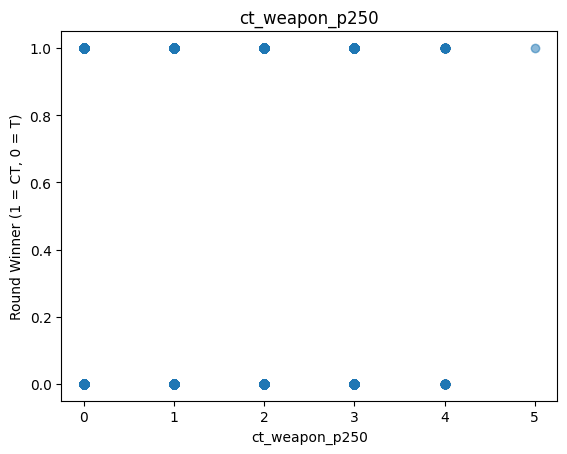

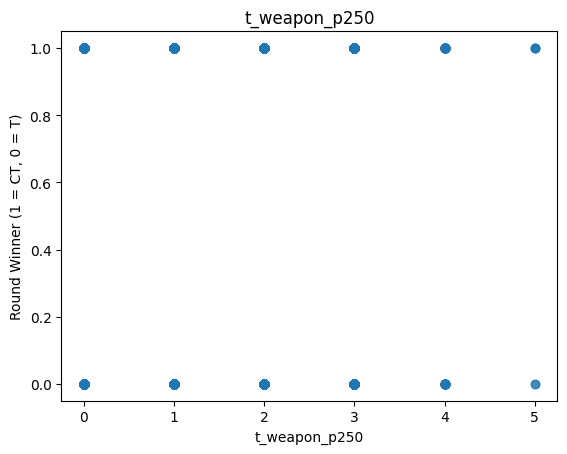

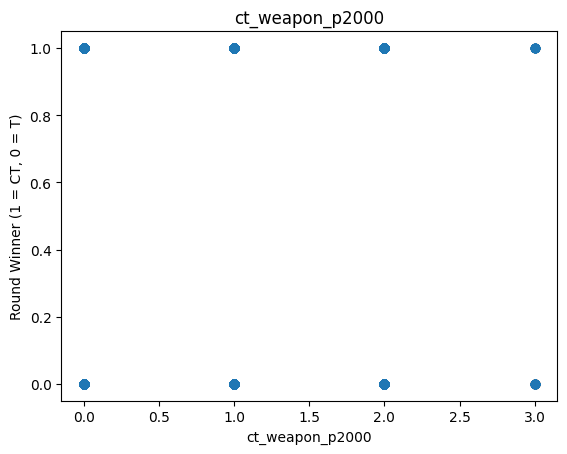

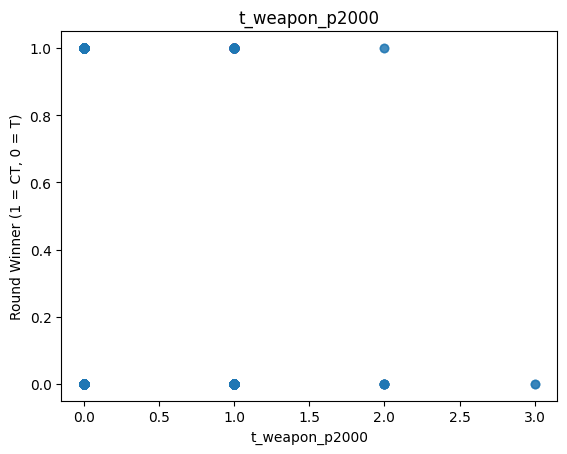

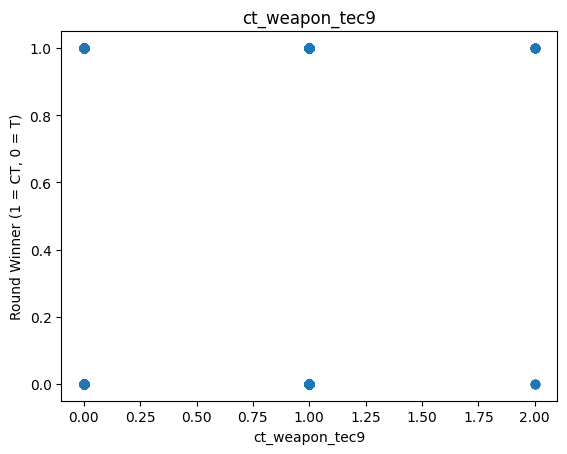

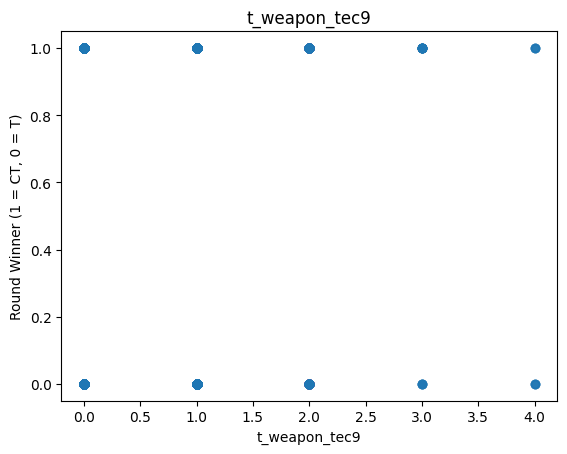

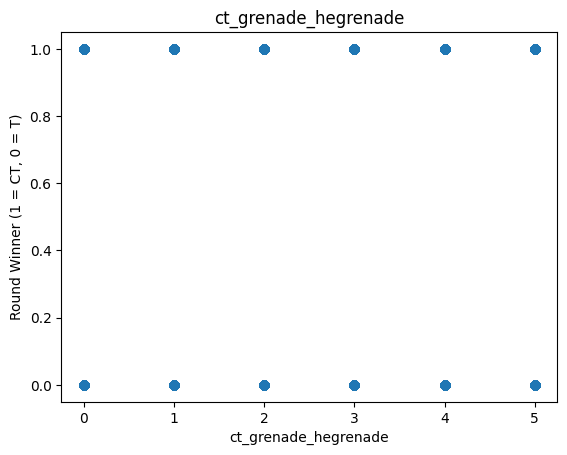

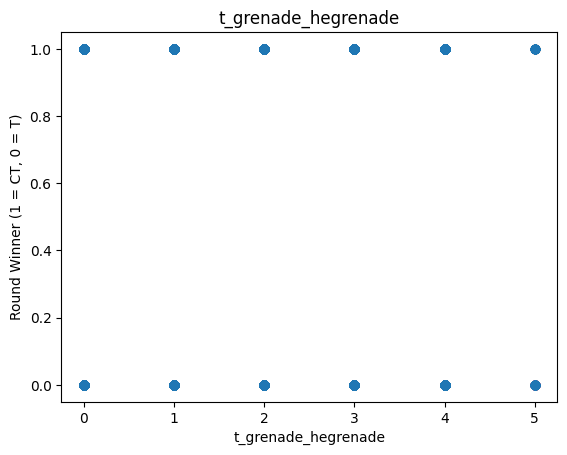

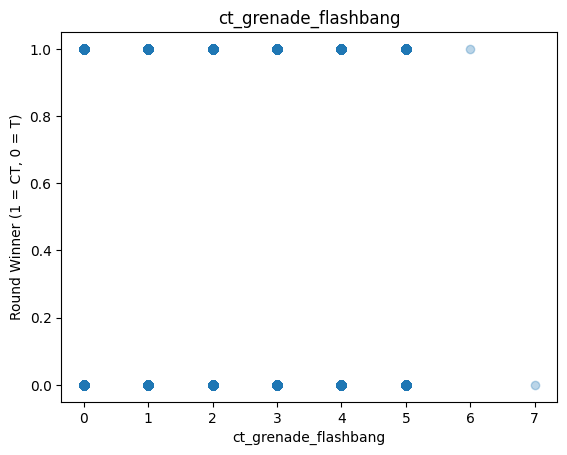

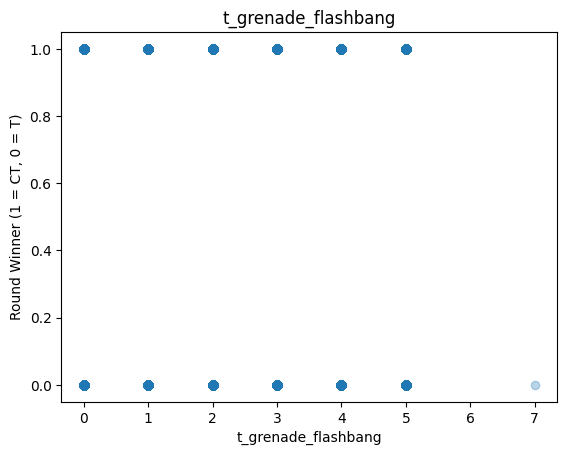

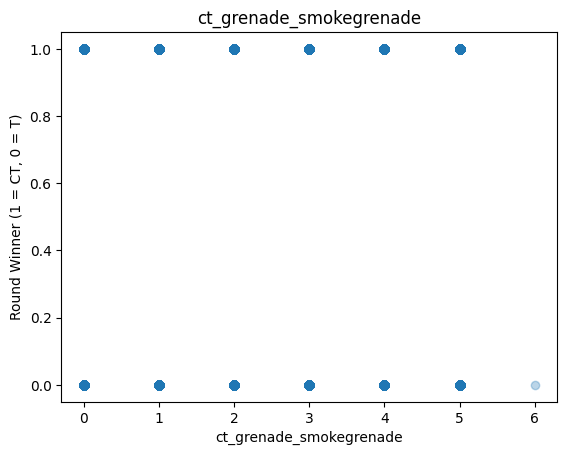

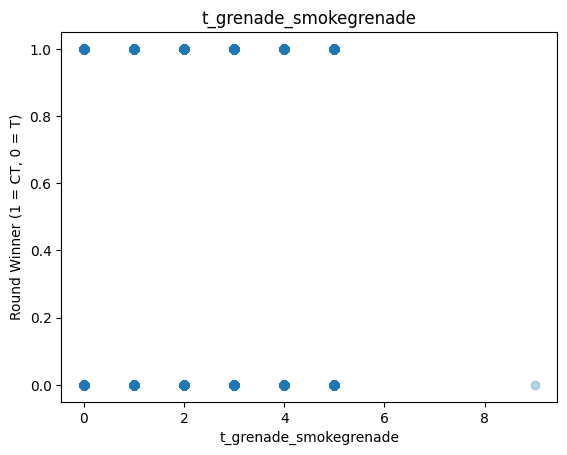

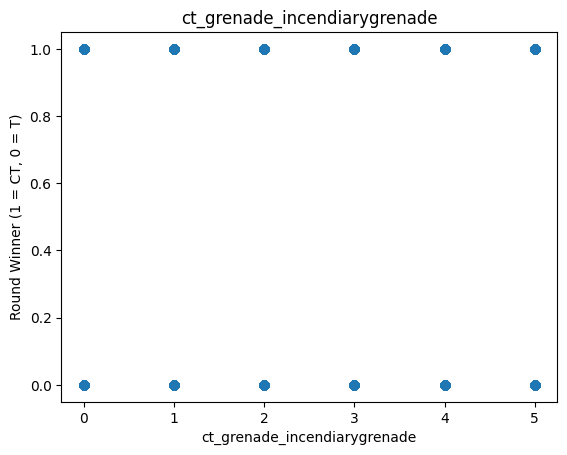

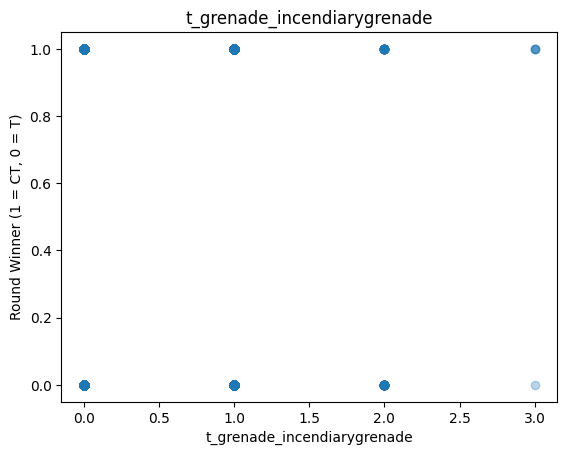

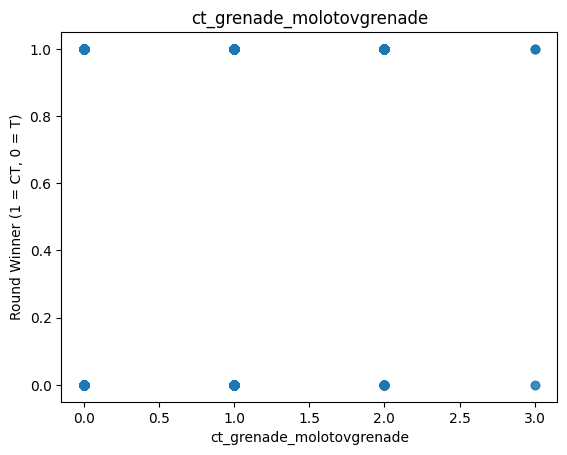

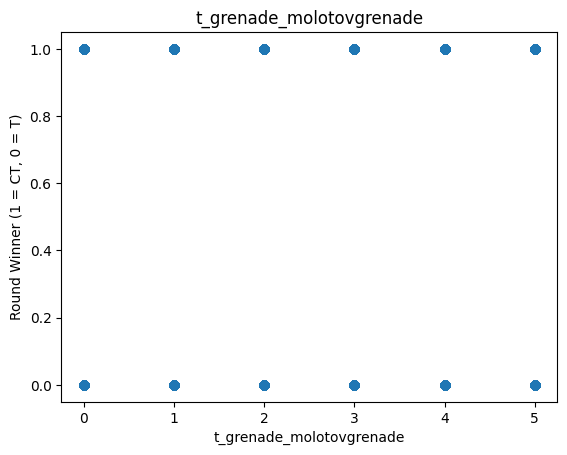

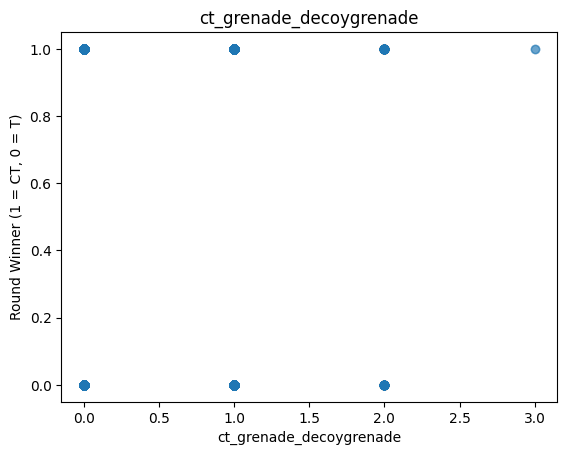

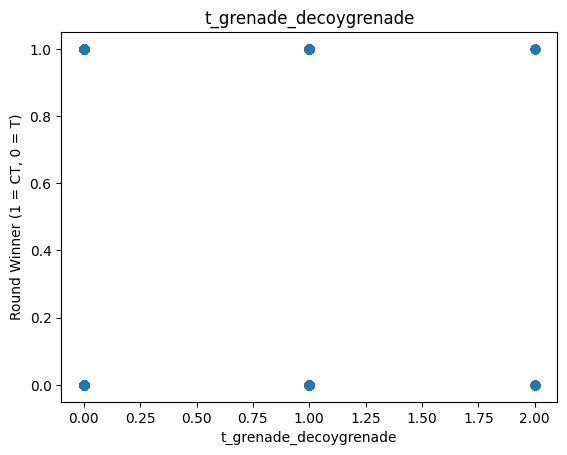

In [48]:
for column, series in numerical_data.items():
    plt.figure()
    plt.scatter(series, target, alpha=0.3)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Round Winner (1 = CT, 0 = T)') 
    plt.show()


In [49]:
categorical_columns = data.select_dtypes('category').columns

/tmp/ipykernel_1252664/3182586604.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


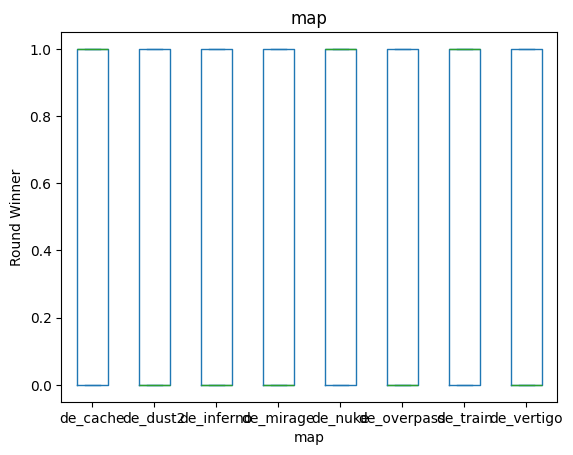

In [50]:
for column in categorical_columns:
    aux_dataframe = data[[column, 'round_winner']]
    aux_dataframe.plot.box(by=column)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Round Winner')
    plt.show()

## Comparing features

In [51]:
corr = data.corr(numeric_only=True)
corr


time_left  ct_score   t_score  bomb_planted  \
time_left                      1.000000  0.000381 -0.003067     -0.486048   
ct_score                       0.000381  1.000000  0.626726     -0.015707   
t_score                       -0.003067  0.626726  1.000000     -0.010080   
bomb_planted                  -0.486048 -0.015707 -0.010080      1.000000   
ct_health                      0.684514  0.016495  0.002840     -0.619132   
t_health                       0.678952 -0.010987  0.001720     -0.448040   
ct_armor                      -0.089950  0.100518  0.035370     -0.281474   
t_armor                       -0.195579  0.034789  0.081671     -0.096619   
ct_money                       0.374530  0.249416  0.069768     -0.190107   
t_money                        0.341717  0.074700  0.258855     -0.125822   
ct_helmets                    -0.103505  0.181513 -0.006872     -0.178893   
t_helmets                     -0.248799  0.063146  0.136555     -0.045942   
ct_defuse_kits                -0.063179  0.250983  0.057492     -0.153495   
ct_players_alive               0.638904  0.014086  0.001216     -0.624645   
t_players_alive                0.597630 -0.015219 -0.003452     -0.399239   
ct_weapon_ak47                -0.003047  0.080039  0.002483     -0.037446   
t_weapon_ak47                 -0.174686  0.052183  0.096578     -0.027465   
ct_weapon_aug                 -0.030657  0.046464  0.007694     -0.048159   
t_weapon_aug                  -0.018829 -0.010911 -0.002346      0.021113   
ct_weapon_awp                 -0.071630  0.206577  0.149292     -0.086814   
t_weapon_awp                  -0.121446  0.107291  0.170017      0.008040   
ct_weapon_cz75auto            -0.042764  0.006316  0.009925     -0.042491   
t_weapon_cz75auto             -0.042994  0.016070  0.005578     -0.013798   
ct_weapon_famas               -0.050244 -0.036209 -0.018739     -0.055062   
t_weapon_famas                -0.016524 -0.027717 -0.017579      0.014711   
ct_weapon_galilar             -0.006377 -0.020971 -0.026480     -0.000725   
t_weapon_galilar              -0.055593 -0.035857 -0.039922     -0.013819   
ct_weapon_glock                0.010914 -0.006860 -0.028950     -0.015413   
t_weapon_glock                 0.521858  0.019991 -0.019404     -0.272186   
ct_weapon_m4a1s               -0.043259  0.065348  0.064575     -0.038293   
ct_weapon_m4a4                -0.135642  0.122191  0.091815     -0.152035   
t_weapon_m4a4                 -0.045112 -0.009674 -0.004606      0.058714   
ct_weapon_mac10               -0.019735 -0.044558 -0.036877      0.018055   
t_weapon_mac10                -0.040115 -0.083303 -0.052505     -0.017594   
ct_weapon_mag7                -0.012313 -0.011261  0.018167     -0.013169   
ct_weapon_mp9                 -0.038363 -0.044062 -0.065742     -0.067484   
t_weapon_mp9                  -0.031995 -0.032060 -0.033546      0.018667   
ct_weapon_sg553                0.007795  0.093160 -0.006662     -0.043492   
t_weapon_sg553                -0.135417  0.074265  0.109405     -0.023831   
ct_weapon_ssg08               -0.050069 -0.096569 -0.059194     -0.019510   
t_weapon_ssg08                -0.026657 -0.027038 -0.057562     -0.014680   
ct_weapon_ump45               -0.035593 -0.031745 -0.027143     -0.031247   
t_weapon_ump45                -0.034045 -0.058261 -0.027614     -0.002212   
ct_weapon_xm1014              -0.013091 -0.004066  0.017996     -0.018659   
ct_weapon_deagle              -0.069891 -0.017361 -0.038367     -0.060462   
t_weapon_deagle               -0.081853 -0.001055 -0.013160     -0.037542   
ct_weapon_fiveseven           -0.035117  0.033752  0.036519     -0.023186   
t_weapon_fiveseven             0.001969 -0.024790  0.018483      0.008692   
ct_weapon_usps                 0.523633 -0.032710 -0.004606     -0.382306   
t_weapon_usps                 -0.026474 -0.144695 -0.049672      0.025521   
ct_weapon_p250                -0.048031  0.141412  0.047149     -0.059679   
t_weapon_p250             

<Axes: >

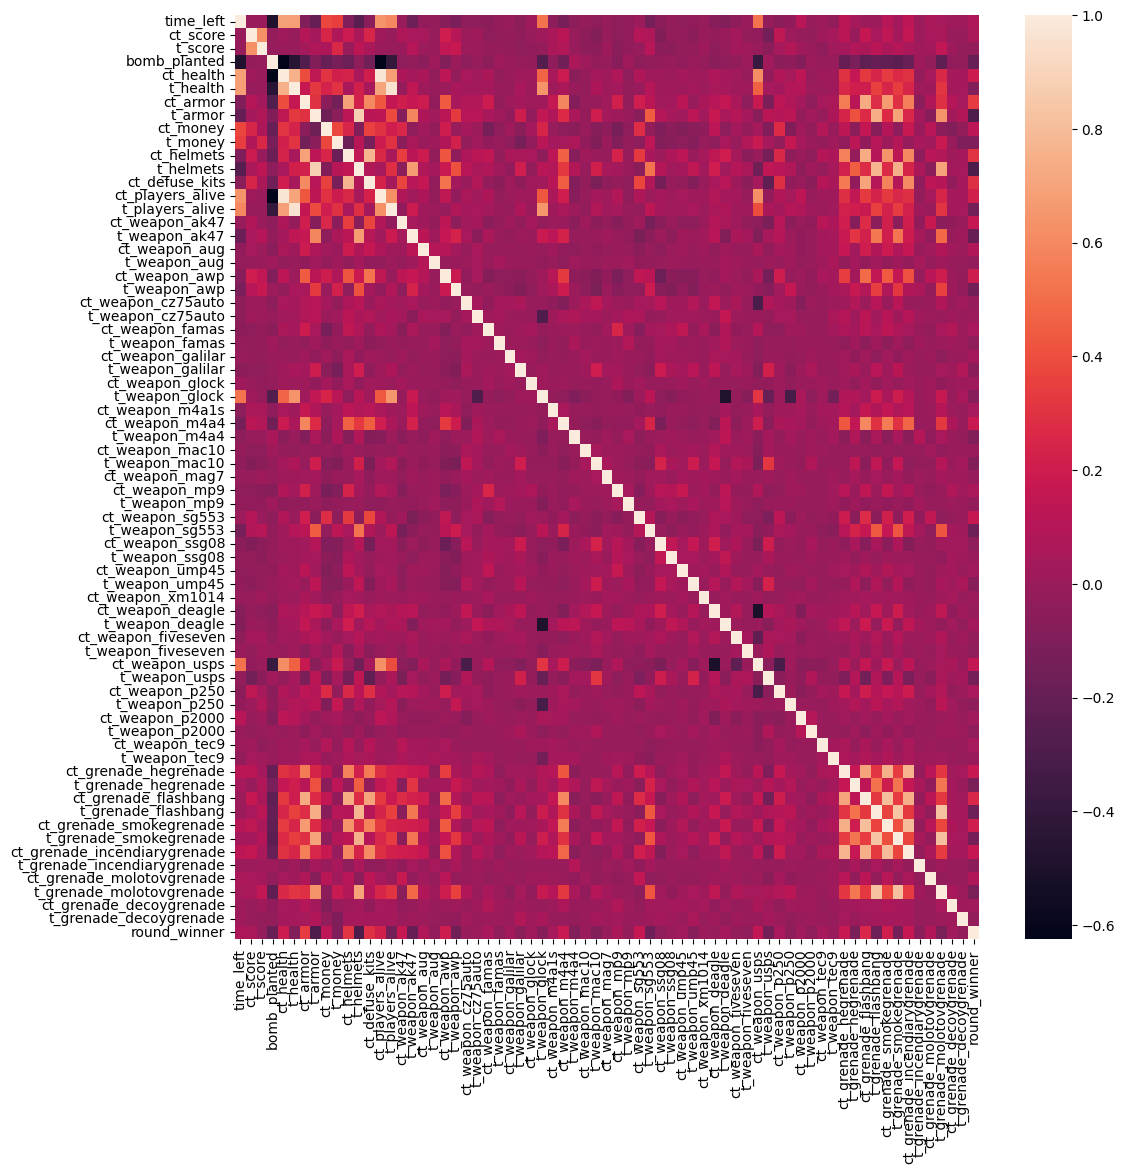

In [52]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=ax)

## Saving cleaned data

In [53]:
clean_data_path = DATA_DIR / 'processed' / 'csgo_clean.pkl'

In [54]:
with open(clean_data_path, 'wb') as file:
    pickle.dump(data, file)